# King County House Sales Analysis Using Mutiple Regression Model

## Libraries

In [943]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from uszipcode import SearchEngine
%matplotlib inline
plt.style.use('seaborn')

## Import data and data cleaning process

In [784]:
df = pd.read_csv('Data/kc_house_data.csv')

In [785]:
df.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
2     10000     1.0         0.0   0.0  ...      6         770            0.0   
3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
4      8080     1.0         0.0   0.0  ...      8        1680            0.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  

[5 rows x 21 columns]

In [786]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


In [787]:
#change the date column name to sold_date and and convert it to date format
df = df.rename(columns={'date':'date_sold'}, errors='raise')
df['date_sold'] = pd.to_datetime(df['date_sold'])

In [788]:
#so I can use data as numercial number in my dataset
df['date_sold'] = df['date_sold'].map(dt.datetime.toordinal)

In [789]:
df.bedrooms.value_counts(normalize=True)

3     0.454878
4     0.318655
2     0.127796
5     0.074131
6     0.012594
1     0.009075
7     0.001760
8     0.000602
9     0.000278
10    0.000139
11    0.000046
33    0.000046
Name: bedrooms, dtype: float64

In [790]:
df.loc[df.bedrooms==33]

id  date_sold     price  bedrooms  bathrooms  sqft_living  \
15856  2402100895     735409  640000.0        33       1.75         1620   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
15856      6000     1.0         0.0   0.0  ...      7        1040   

       sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
15856          580.0     1947           0.0    98103  47.6878 -122.331   

       sqft_living15  sqft_lot15  
15856           1330        4700  

[1 rows x 21 columns]

In [791]:
# df.loc[(df.bedrooms==3) & (df.bathrooms==2) & (df.floors==1) & (df.sqft_living>1600) & (df.basement==1)]

In [792]:
#33 bedrooms is definitely a typo and needs to be addresed
df.loc[df.bedrooms==33,'bedrooms'] = 3

In [793]:
df.loc[df.bedrooms==11]

id  date_sold     price  bedrooms  bathrooms  sqft_living  \
8748  1773100755     735466  520000.0        11        3.0         3000   

      sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
8748      4960     2.0         0.0   0.0  ...      7        2400   

      sqft_basement yr_built  yr_renovated  zipcode     lat     long  \
8748          600.0     1918        1999.0    98106  47.556 -122.363   

      sqft_living15  sqft_lot15  
8748           1420        4960  

[1 rows x 21 columns]

In [794]:
# df.loc[(df.bedrooms==10) & (df.bathrooms==3) & (df.floors==2) & (df.sqft_living>2500) & (df.basement==1)]

In [795]:
#there is only 1 house that has 11 bedrooms. we can consider it as 10 bedrooms
df.loc[df.bedrooms==11,'bedrooms'] = 10

In [796]:
df.bathrooms.value_counts(normalize=True)

2.50    0.248970
1.00    0.178312
1.75    0.141131
2.25    0.094782
2.00    0.089364
1.50    0.066907
2.75    0.054869
3.00    0.034866
3.50    0.033847
3.25    0.027272
3.75    0.007177
4.00    0.006297
4.50    0.004630
4.25    0.003658
0.75    0.003287
4.75    0.001065
5.00    0.000972
5.25    0.000602
5.50    0.000463
1.25    0.000417
6.00    0.000278
5.75    0.000185
0.50    0.000185
8.00    0.000093
6.25    0.000093
6.75    0.000093
6.50    0.000093
7.50    0.000046
7.75    0.000046
Name: bathrooms, dtype: float64

In [797]:
# df.bathrooms = df.bathrooms.astype(str)
# df.bathrooms.value_counts

<bound method IndexOpsMixin.value_counts of 0         1.0
1        2.25
2         1.0
3         3.0
4         2.0
         ... 
21592     2.5
21593     2.5
21594    0.75
21595     2.5
21596    0.75
Name: bathrooms, Length: 21597, dtype: object>

In [798]:
# df['bathrooms'] = df.bathrooms.map(lambda x: x.replace(' ',''))

In [799]:
# df.bathrooms = df.bathrooms.astype(float)

In [800]:
#define a function to round the number of bathrooms to the nearest integer
def num_round(x):
    if ((x*10)%10)>=5:
        y=math.ceil(x)
    else:
        y=math.floor(x)
    return y

In [801]:
#apply the function and change the type to int
df['bathrooms']=df.bathrooms.apply(num_round).astype(int)

In [950]:
df.bathrooms.value_counts(normalize=True)

2    0.392184
3    0.365977
1    0.182201
4    0.050979
5    0.007270
6    0.001019
8    0.000185
7    0.000185
Name: bathrooms, dtype: float64

In [803]:
#change the type of floor column from float to int
df.floors = df.floors.astype(int)
df.floors.value_counts(normalize=True)

1    0.582627
2    0.388758
3    0.028615
Name: floors, dtype: float64

In [804]:
#in 21597 rows of data only 146 of houses has waterfront view, so I decided to fill NaN values (around 2500 houses)
#with 0 and also change the type to int aswell.
df.waterfront = df.waterfront.fillna(0)
df["waterfront"] = pd.to_numeric(df["waterfront"]).astype(int)
df.waterfront.value_counts(normalize=True)

0    0.99324
1    0.00676
Name: waterfront, dtype: float64

In [805]:
#there is a '?' int the values of sqft_basement which makes it an object type column. Issue tackled
#and datatype chaned to int
df.loc[df.sqft_basement == '?', 'sqft_basement'] = '0.0'
df.sqft_basement = df.sqft_basement.astype(float).astype(int)
df.sqft_basement

0          0
1        400
2          0
3        910
4          0
        ... 
21592      0
21593      0
21594      0
21595      0
21596      0
Name: sqft_basement, Length: 21597, dtype: int64

In [806]:
#more than half of the houses don't have basement(13280)
df.loc[df.sqft_basement == 0, 'sqft_basement']

0        0
2        0
4        0
6        0
7        0
        ..
21592    0
21593    0
21594    0
21595    0
21596    0
Name: sqft_basement, Length: 13280, dtype: int64

In [807]:
#let's make a column that can be considered as categorical (df.basement)
# 1 considered as has basement and 0 considered as no basement
def h_basement(x):
    if x>0:
        y=1
    else:
        y=0
    return y
        
    
    
df['basement'] = df.sqft_basement.apply(h_basement)
df.basement.value_counts(normalize=True)

0    0.6149
1    0.3851
Name: basement, dtype: float64

In [808]:
df.yr_renovated.describe()

count    17755.000000
mean        83.636778
std        399.946414
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2015.000000
Name: yr_renovated, dtype: float64

In [809]:
df['renovated'] = df.yr_renovated.fillna(0.0).astype(int)
df['renovated'] = df.renovated.apply(h_basement)
df.renovated.value_counts(normalize=True)

0    0.965551
1    0.034449
Name: renovated, dtype: float64

In [810]:
#to check how many values in view column are 0
df.loc[df.view == 0, 'view']

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
21592    0.0
21593    0.0
21594    0.0
21595    0.0
21596    0.0
Name: view, Length: 19422, dtype: float64

In [811]:
#droping unnecessary columns.
#most of the values in yr_renovated are 0 
#19422 values of view are 0 which is not related to price(the target varible) 
df = df.drop(columns=['view','yr_renovated'], axis=1)

In [812]:
#rescaling 'condition' column from 1-5 to 0-4
#rescaling 'grade' column from 3-13 to 0-10
#created different column names, in case of running the code more than once
df['res_condition'] = df['condition'].map(lambda x: x-1)
df['res_grade'] = df['grade'].map(lambda x: x-3)

In [813]:
df.res_grade.value_counts(normalize=True)

4     0.415521
5     0.280826
6     0.121082
3     0.094365
7     0.052507
8     0.018475
2     0.011205
9     0.004121
1     0.001250
10    0.000602
0     0.000046
Name: res_grade, dtype: float64

In [814]:
df.res_condition.value_counts(normalize=True)

2    0.649164
3    0.262861
4    0.078761
1    0.007871
0    0.001343
Name: res_condition, dtype: float64

In [815]:
#to prevent redundancy, I delete the following columns
df = df.drop(columns=['condition','grade'], axis=1)

In [816]:
#there are some duplicate rows that needs to be droped
df.id.duplicated().sum()

177

In [817]:
df.id.drop_duplicates(inplace=True)
df = df.drop(columns=['id','sqft_basement'], axis=1)

In [818]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 19 columns):
date_sold        21597 non-null int64
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null int64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null int64
waterfront       21597 non-null int64
sqft_above       21597 non-null int64
yr_built         21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
basement         21597 non-null int64
renovated        21597 non-null int64
res_condition    21597 non-null int64
res_grade        21597 non-null int64
dtypes: float64(3), int64(16)
memory usage: 3.1 MB


## Dealing with categorical and continuous Variables

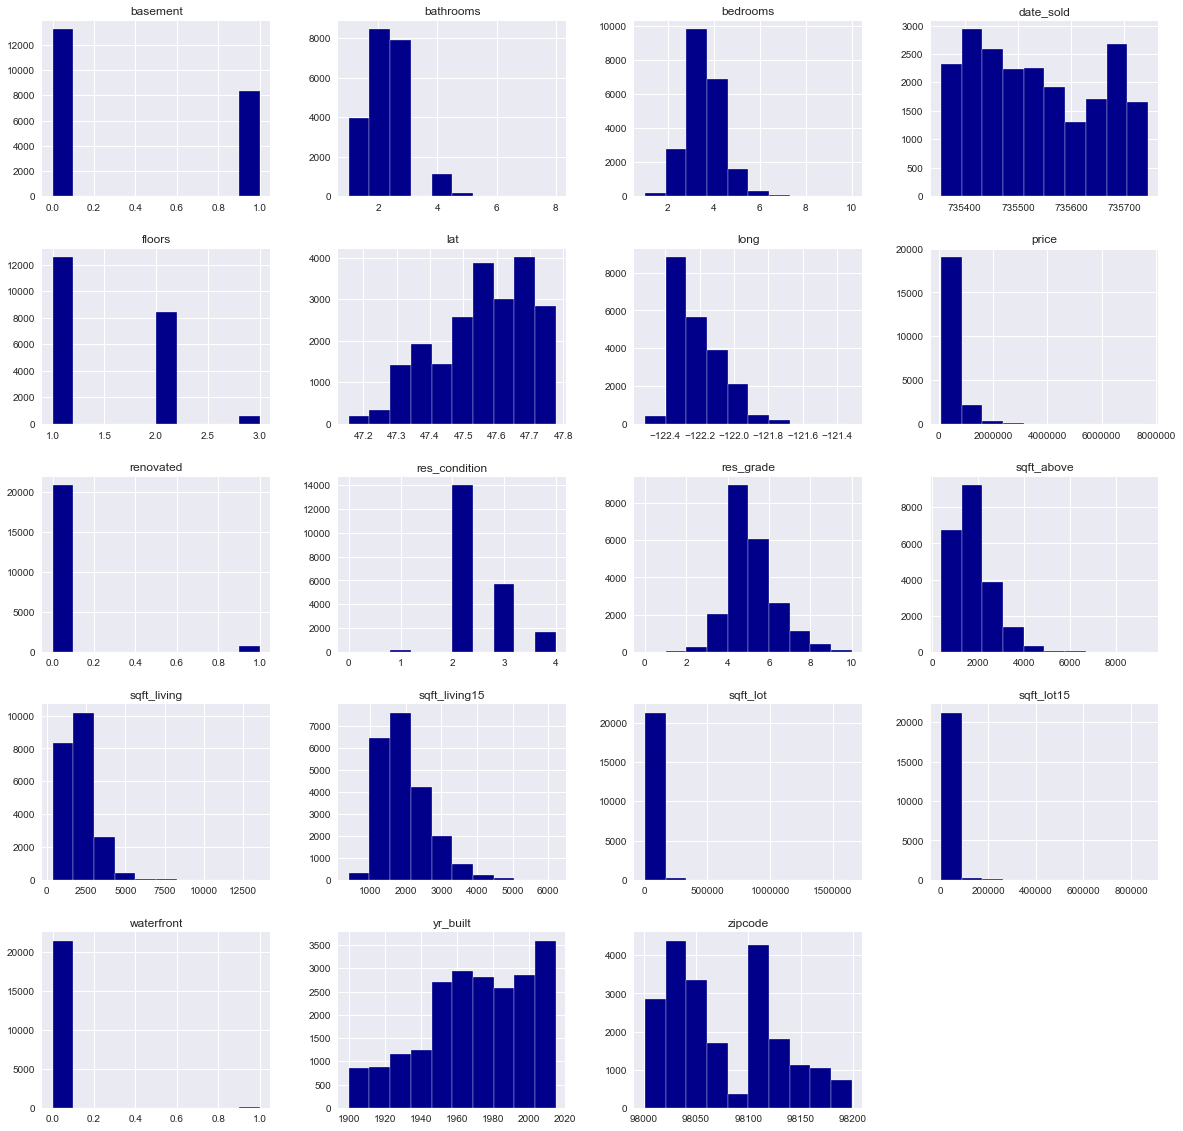

In [819]:
df.hist(figsize=(20,20),color='darkblue');

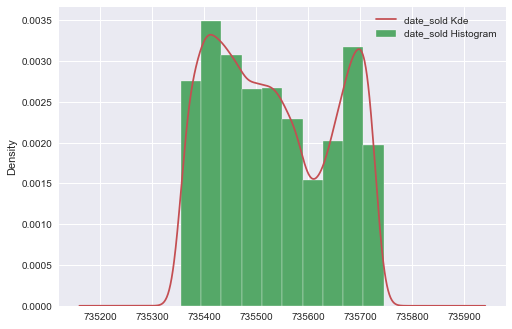

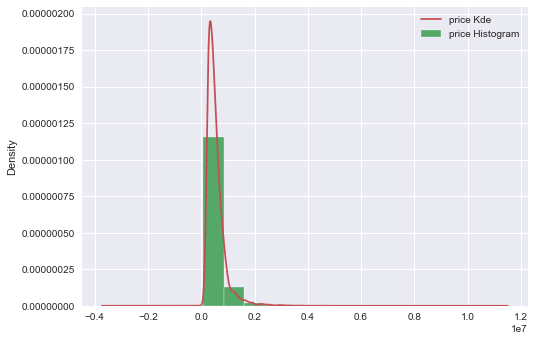

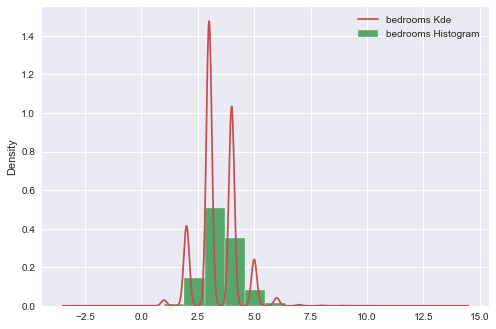

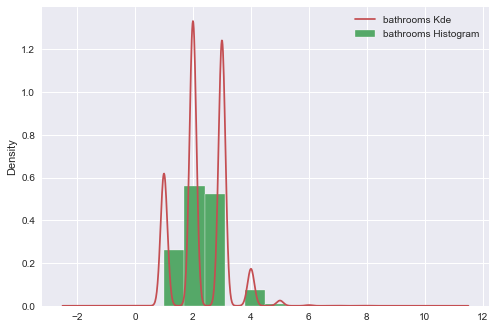

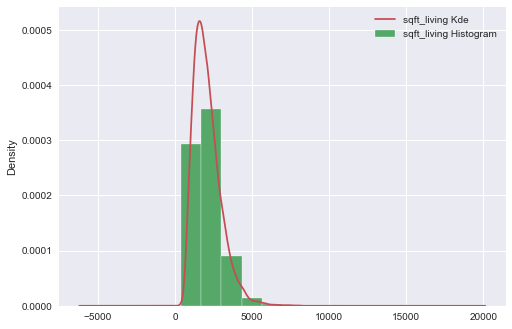

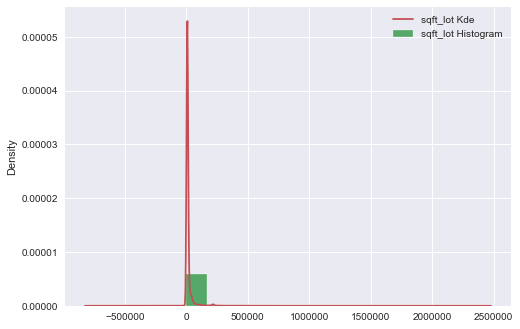

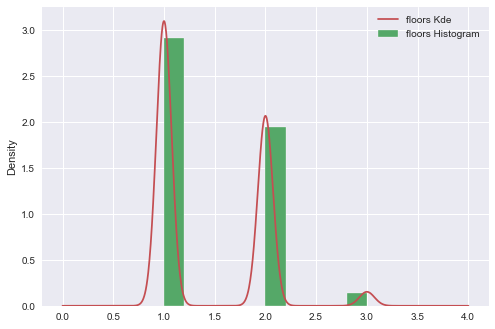

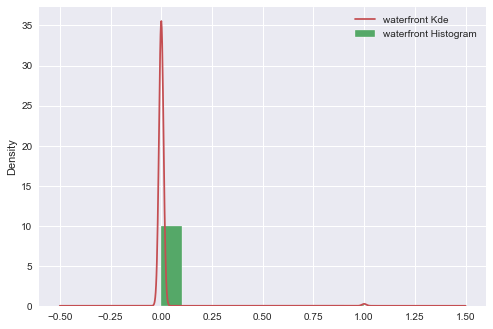

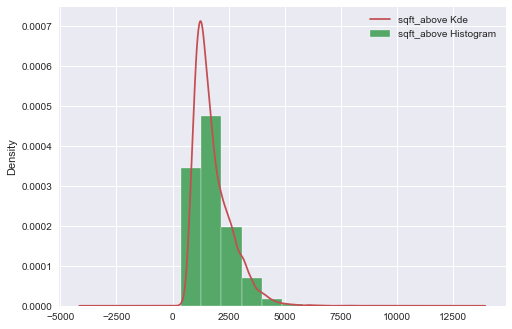

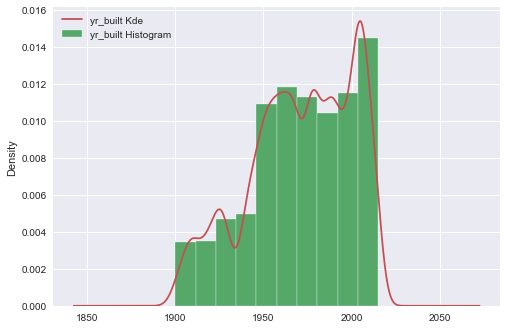

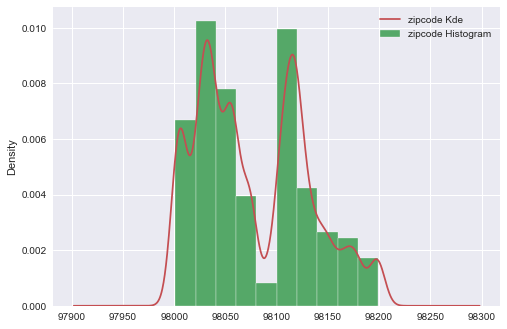

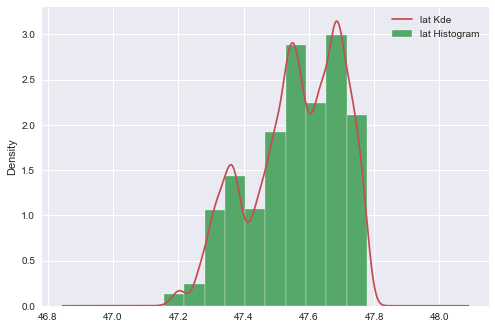

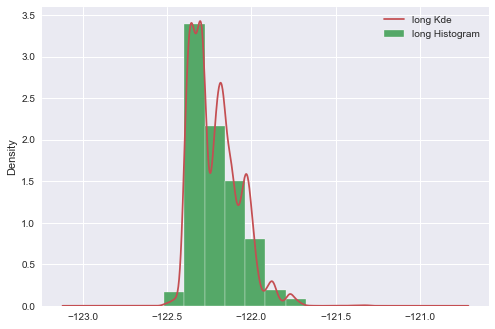

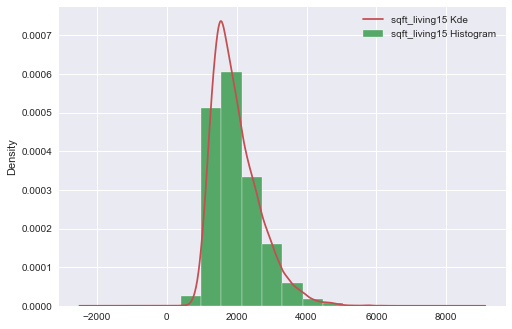

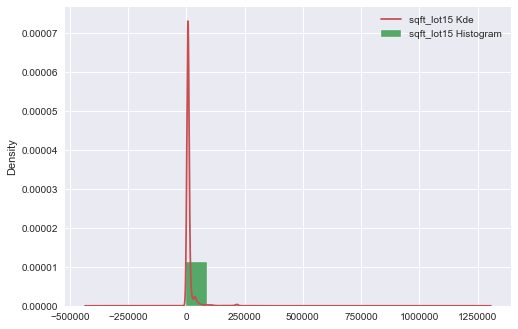

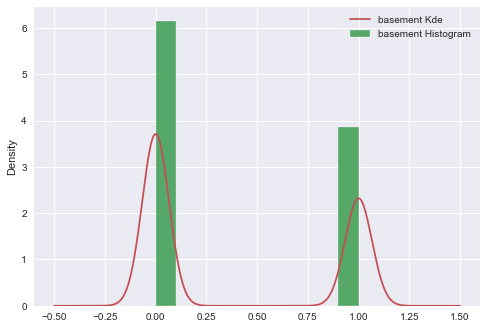

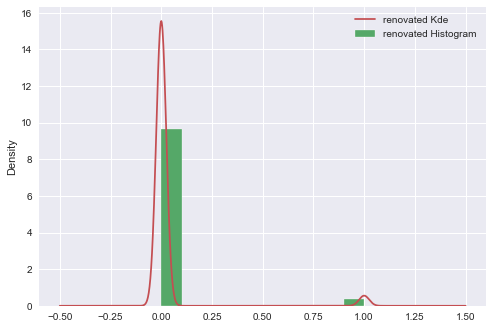

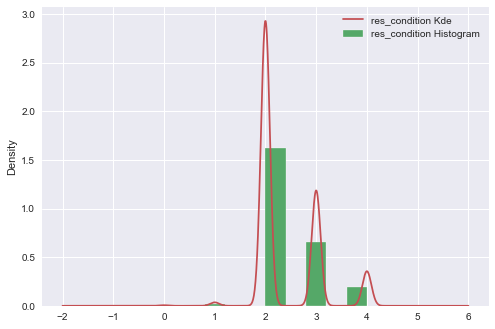

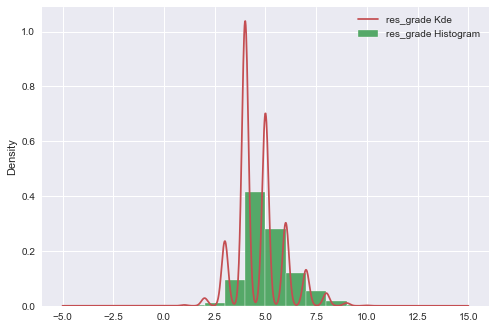

In [820]:
# For all the variables, check distribution by creating a histogram with kde

for column in df:
    try:
        df[column].plot.hist(density=True, color='g', label=column+' Histogram')
        df[column].plot.kde(color='r', label=column+' Kde')
        plt.legend()
        plt.show()
    except:
        continue

In [821]:
#based on my assumptions of what columns can be categorical and what columns can be continuous 
#I split the DF columns into two groups of categorical and continuous
categoricals = ['bedrooms','bathrooms','floors','waterfront','res_condition','res_grade','basement','renovated']
continuous = ['date_sold','sqft_living','sqft_lot','sqft_above',
              'yr_built','zipcode','lat','long','sqft_living15','sqft_lot15']

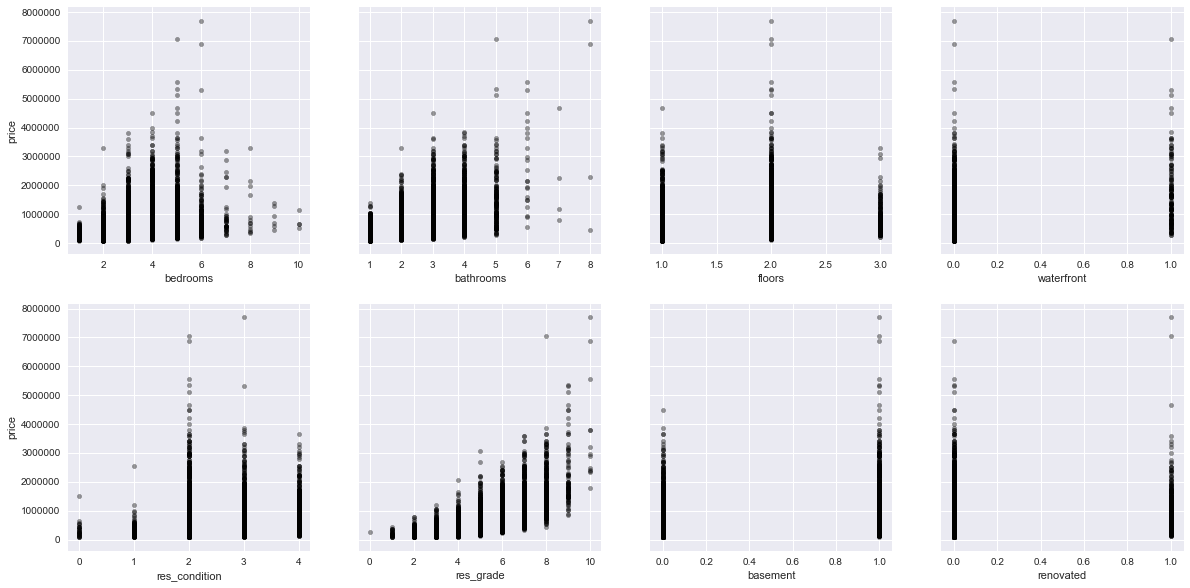

In [822]:
#to check our categoricals by scatter plot
fig, axes = plt.subplots(nrows=2,ncols=4,sharey=True, figsize=(20,10))
for col,ax in zip(categoricals,axes.flatten()):
    df.plot(kind='scatter', x=col,y='price',ax=ax, alpha=0.4, color='black')

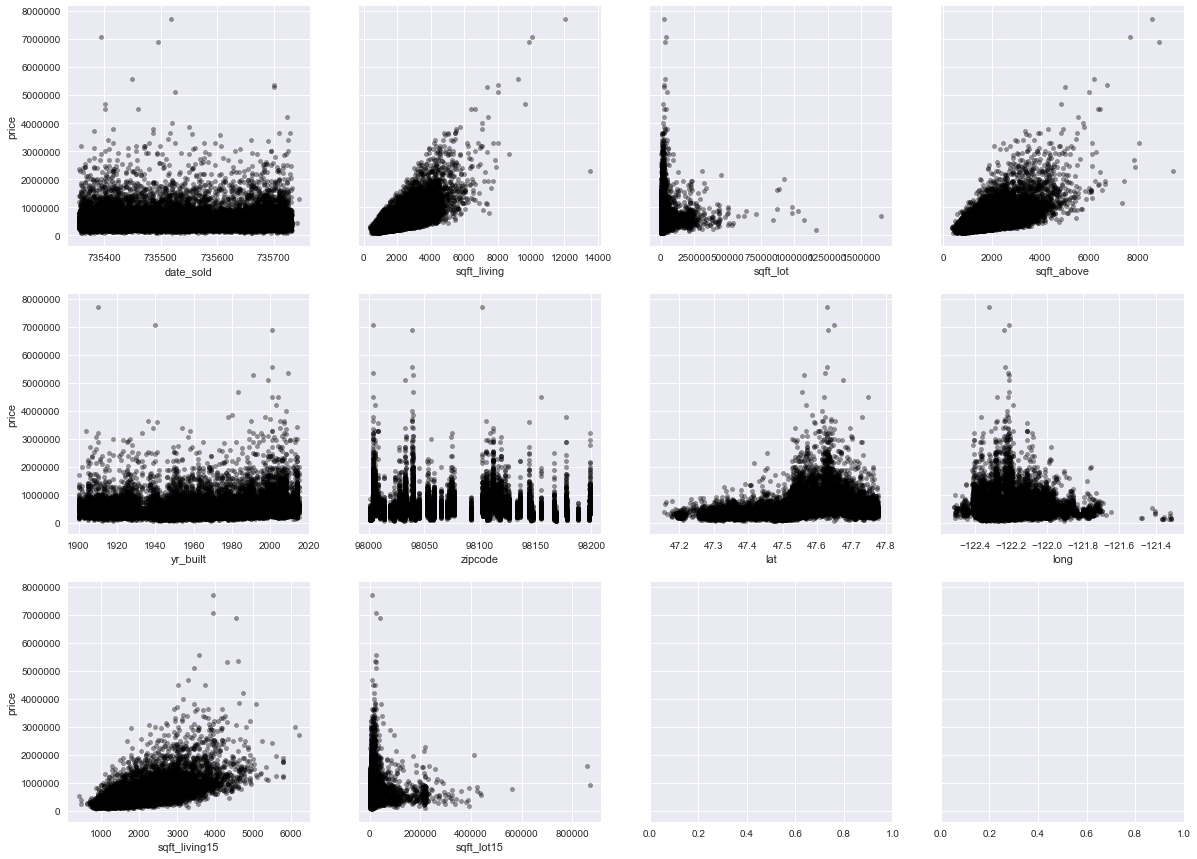

In [823]:
#to check our continuous variables bu scatter plots
#it seems that zipcodes are more looklile categorical variables but we want to consider them as continuous

fig, axes = plt.subplots(nrows=3,ncols=4,sharey=True, figsize=(20,15))
for col,ax in zip(continuous,axes.flatten()):
    df.plot(kind='scatter', x=col,y='price',ax=ax, alpha=0.4, color='black')

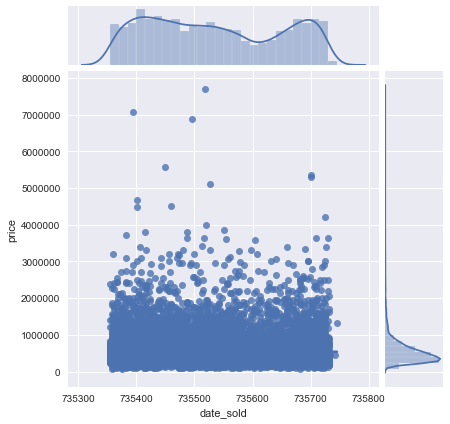

In [824]:
#let's have jointplots to study linearity between different predictors
sns.jointplot(x='date_sold',y='price',data=df,kind='reg',height=6,ratio=5,space=.1);

#lookslike there is no linear relationship between date_sold and price

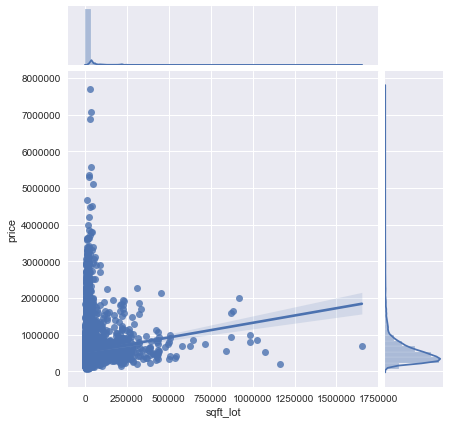

In [825]:
sns.jointplot(x='sqft_lot',y='price',data=df,kind='reg',height=6,ratio=5,space=.1);

#a little to no linearity between sqft_lot and price

In [826]:
#Dealing with categorical variables by ohe
dummies = df[categoricals].astype('category')
dummies = pd.get_dummies(dummies,prefix=categoricals, drop_first=True)
df_preprocessed = df.drop(categoricals, axis=1)
df_preprocessed = pd.concat([df_preprocessed, dummies], axis=1)

df_preprocessed.head()

date_sold     price  sqft_living  sqft_lot  sqft_above  yr_built  zipcode  \
0     735519  221900.0         1180      5650        1180      1955    98178   
1     735576  538000.0         2570      7242        2170      1951    98125   
2     735654  180000.0          770     10000         770      1933    98028   
3     735576  604000.0         1960      5000        1050      1965    98136   
4     735647  510000.0         1680      8080        1680      1987    98074   

       lat     long  sqft_living15  ...  res_grade_3  res_grade_4  \
0  47.5112 -122.257           1340  ...            0            1   
1  47.7210 -122.319           1690  ...            0            1   
2  47.7379 -122.233           2720  ...            1            0   
3  47.5208 -122.393           1360  ...            0            1   
4  47.6168 -122.045           1800  ...            0            0   

   res_grade_5  res_grade_6  res_grade_7  res_grade_8  res_grade_9  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            1            0            0            0            0   

   res_grade_10  basement_1  renovated_1  
0             0           0            0  
1             0           1            1  
2             0           0            0  
3             0           1            0  
4             0           0            0  

[5 rows x 46 columns]

In [827]:
#create a dataframe that conside zipcode as categorical variable
df_zip = pd.get_dummies(df.zipcode,prefix='zipcode', drop_first=True)
df_preprocessed_zip = pd.concat([df_preprocessed,df_zip], axis=1)
df_preprocessed_zip.drop('zipcode', axis=1,inplace=True)

## Multicolinearity of features

In [828]:
df.head()

date_sold     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0     735519  221900.0         3          1         1180      5650       1   
1     735576  538000.0         3          2         2570      7242       2   
2     735654  180000.0         2          1          770     10000       1   
3     735576  604000.0         4          3         1960      5000       1   
4     735647  510000.0         3          2         1680      8080       1   

   waterfront  sqft_above  yr_built  zipcode      lat     long  sqft_living15  \
0           0        1180      1955    98178  47.5112 -122.257           1340   
1           0        2170      1951    98125  47.7210 -122.319           1690   
2           0         770      1933    98028  47.7379 -122.233           2720   
3           0        1050      1965    98136  47.5208 -122.393           1360   
4           0        1680      1987    98074  47.6168 -122.045           1800   

   sqft_lot15  basement  renovated  res_condition  res_grade  
0        5650         0          0              2          4  
1        7639         1          1              2          4  
2        8062         0          0              2          3  
3        5000         1          0              4          4  
4        7503         0          0              2          5

In [829]:
#we saw that date_sold and yr_built are not related to price(our target variable) 
data_pred = df.iloc[:,2:]
data_pred

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0             3          1         1180      5650       1           0   
1             3          2         2570      7242       2           0   
2             2          1          770     10000       1           0   
3             4          3         1960      5000       1           0   
4             3          2         1680      8080       1           0   
...         ...        ...          ...       ...     ...         ...   
21592         3          3         1530      1131       3           0   
21593         4          3         2310      5813       2           0   
21594         2          1         1020      1350       2           0   
21595         3          3         1600      2388       2           0   
21596         2          1         1020      1076       2           0   

       sqft_above  yr_built  zipcode      lat     long  sqft_living15  \
0            1180      1955    98178  47.5112 -122.257           1340   
1            2170      1951    98125  47.7210 -122.319           1690   
2             770      1933    98028  47.7379 -122.233           2720   
3            1050      1965    98136  47.5208 -122.393           1360   
4            1680      1987    98074  47.6168 -122.045           1800   
...           ...       ...      ...      ...      ...            ...   
21592        1530      2009    98103  47.6993 -122.346           1530   
21593        2310      2014    98146  47.5107 -122.362           1830   
21594        1020      2009    98144  47.5944 -122.299           1020   
21595        1600      2004    98027  47.5345 -122.069           1410   
21596        1020      2008    98144  47.5941 -122.299           1020   

       sqft_lot15  basement  renovated  res_condition  res_grade  
0            5650         0          0              2          4  
1            7639         1          1              2          4  
2            8062         0          0              2          3  
3            5000         1          0              4          4  
4            7503         0          0              2          5  
...           ...       ...        ...            ...        ...  
21592        1509         0          0              2          5  
21593        7200         0          0              2          5  
21594        2007         0          0              2          4  
21595        1287         0          0              2          5  
21596        1357         0          0              2          4  

[21597 rows x 17 columns]

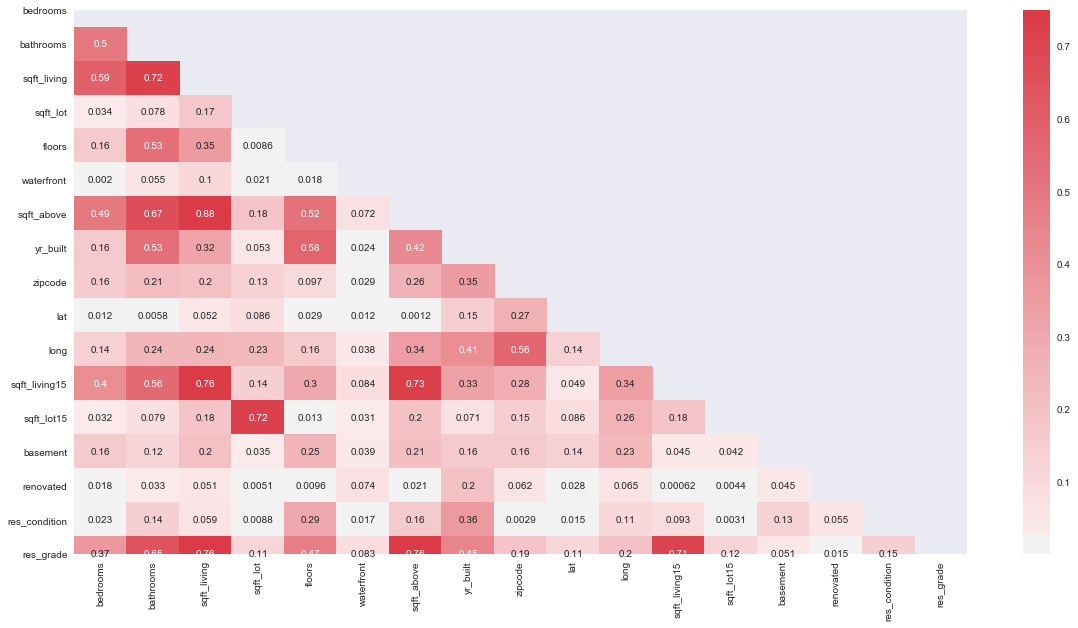

In [830]:
#define a function to create our heatmap
def check_multicol(df):
    fig, ax = plt.subplots(figsize=(20,10)) 
    corr = df.corr().abs()
    mask = np.triu(np.ones_like(corr,dtype=bool))
    cmap = sns.diverging_palette(220,10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.75, center=0, annot=True,ax=ax)
    

check_multicol(data_pred)    

In [831]:
#hard to read the heatmap so let's deal with numbers
data_pred.corr()

bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
bedrooms       1.000000   0.503900     0.593371  0.033632  0.163203   
bathrooms      0.503900   1.000000     0.720891  0.077786  0.531786   
sqft_living    0.593371   0.720891     1.000000  0.173453  0.353372   
sqft_lot       0.033632   0.077786     0.173453  1.000000 -0.008603   
floors         0.163203   0.531786     0.353372 -0.008603  1.000000   
waterfront    -0.002049   0.055063     0.104637  0.021459  0.018321   
sqft_above     0.492710   0.672287     0.876448  0.184139  0.518037   
yr_built       0.160905   0.531314     0.318152  0.052946  0.578549   
zipcode       -0.158687  -0.213088    -0.199802 -0.129586 -0.097146   
lat           -0.011615   0.005834     0.052155 -0.085514  0.029218   
long           0.136684   0.244918     0.241214  0.230227  0.159481   
sqft_living15  0.404746   0.557092     0.756402  0.144763  0.296797   
sqft_lot15     0.031925   0.078946     0.184342  0.718204 -0.012766   
basement       0.160361   0.118407     0.201198 -0.034889 -0.246878   
renovated      0.018094   0.032800     0.050829  0.005091 -0.009580   
res_condition  0.023432  -0.144485    -0.059445 -0.008830 -0.293463   
res_grade      0.366357   0.646424     0.762779  0.114731  0.473273   

               waterfront  sqft_above  yr_built   zipcode       lat      long  \
bedrooms        -0.002049    0.492710  0.160905 -0.158687 -0.011615  0.136684   
bathrooms        0.055063    0.672287  0.531314 -0.213088  0.005834  0.244918   
sqft_living      0.104637    0.876448  0.318152 -0.199802  0.052155  0.241214   
sqft_lot         0.021459    0.184139  0.052946 -0.129586 -0.085514  0.230227   
floors           0.018321    0.518037  0.578549 -0.097146  0.029218  0.159481   
waterfront       1.000000    0.071778 -0.024487  0.028923 -0.012157 -0.037628   
sqft_above       0.071778    1.000000  0.424037 -0.261570 -0.001199  0.344842   
yr_built        -0.024487    0.424037  1.000000 -0.347210 -0.148370  0.409993   
zipcode          0.028923   -0.261570 -0.347210  1.000000  0.266742 -0.564259   
lat             -0.012157   -0.001199 -0.148370  0.266742  1.000000 -0.135371   
long            -0.037628    0.344842  0.409993 -0.564259 -0.135371  1.000000   
sqft_living15    0.083823    0.731767  0.326377 -0.279299  0.048679  0.335626   
sqft_lot15       0.030658    0.195077  0.070777 -0.147294 -0.086139  0.255586   
basement         0.039220   -0.207268 -0.163992  0.159599  0.136602 -0.233366   
renovated        0.074267    0.020566 -0.202837  0.062378  0.027908 -0.064511   
res_condition    0.016648   -0.158904 -0.361592  0.002888 -0.015102 -0.105877   
res_grade        0.082818    0.756073  0.447865 -0.185771  0.113575  0.200341   

               sqft_living15  sqft_lot15  basement  renovated  res_condition  \
bedrooms            0.404746    0.031925  0.160361   0.018094       0.023432   
bathrooms           0.557092    0.078946  0.118407   0.032800      -0.144485   
sqft_living         0.756402    0.184342  0.201198   0.050829      -0.059445   
sqft_lot            0.144763    0.718204 -0.034889   0.005091      -0.008830   
floors              0.296797   -0.012766 -0.246878  -0.009580      -0.293463   
waterfront          0.083823    0.030658  0.039220   0.074267       0.016648   
sqft_above          0.731767    0.195077 -0.207268   0.020566      -0.158904   
yr_built            0.326377    0.070777 -0.163992  -0.202837      -0.361592   
zipcode            -0.279299   -0.147294  0.159599   0.062378       0.002888   
lat                 0.048679   -0.086139  0.136602   0.027908      -0.015102   
long                0.335626    0.255586 -0.233366  -0.064511      -0.105877   
sqft_living15       1.000000    0.183515  0.044577   0.000622      -0.093072   
sqft_lot15          0.183515    1.000000 -0.041747   0.004380      -0.003126   
basement            0.044577   -0.041747  1.000000   0.044600       0.130542   
renovated           0.000622    0.004380  0.044600   1.000000      -0.055383 

In [832]:
data_corr = data_pred.corr().abs().stack().reset_index().sort_values(0,ascending=False)
data_corr['pairs'] = list(zip(data_corr.level_0,data_corr.level_1))
data_corr.set_index(['pairs'],inplace=True)
data_corr.drop(columns=['level_0','level_1'],inplace=True)
data_corr.columns = ['Correlation']
data_corr.drop_duplicates(inplace=True)
data_corr[(data_corr.Correlation>.75)&(data_corr.Correlation<1)]


Correlation
pairs                                    
(sqft_living, sqft_above)        0.876448
(res_grade, sqft_living)         0.762779
(sqft_living, sqft_living15)     0.756402
(sqft_above, res_grade)          0.756073

In [833]:
data_corr[(data_corr.Correlation>.5)&(data_corr.Correlation<1)]

Correlation
pairs                                    
(sqft_living, sqft_above)        0.876448
(res_grade, sqft_living)         0.762779
(sqft_living, sqft_living15)     0.756402
(sqft_above, res_grade)          0.756073
(sqft_above, sqft_living15)      0.731767
(bathrooms, sqft_living)         0.720891
(sqft_lot15, sqft_lot)           0.718204
(res_grade, sqft_living15)       0.713867
(bathrooms, sqft_above)          0.672287
(bathrooms, res_grade)           0.646424
(sqft_living, bedrooms)          0.593371
(floors, yr_built)               0.578549
(long, zipcode)                  0.564259
(bathrooms, sqft_living15)       0.557092
(floors, bathrooms)              0.531786
(bathrooms, yr_built)            0.531314
(sqft_above, floors)             0.518037
(bedrooms, bathrooms)            0.503900

## Log Transform, Feature Scaling, and Normalization

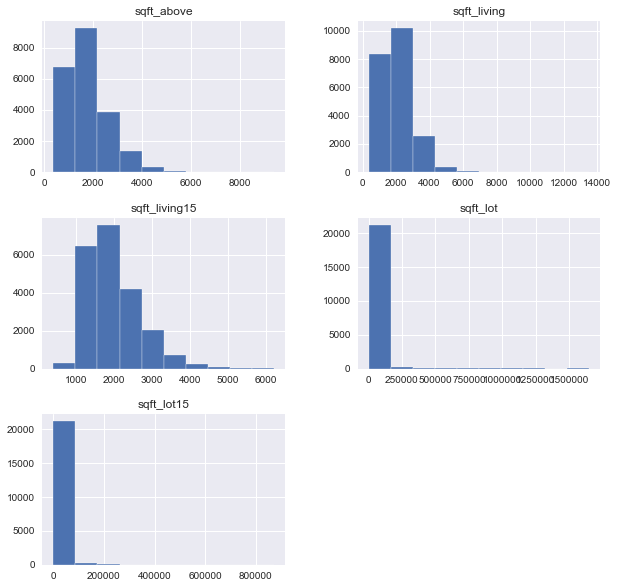

In [834]:
#these are some continous variables that seems abnormal
feat = ['sqft_living','sqft_lot','sqft_above','sqft_living15','sqft_lot15']
df[feat].hist(figsize = (10,10));

In [835]:
#let's do some log transform to see if it helps with normal distribution or not
data_log = pd.DataFrame([])
for col in feat:
    data_log[col+'_log'] = df[col].map(lambda x: np.log(x))

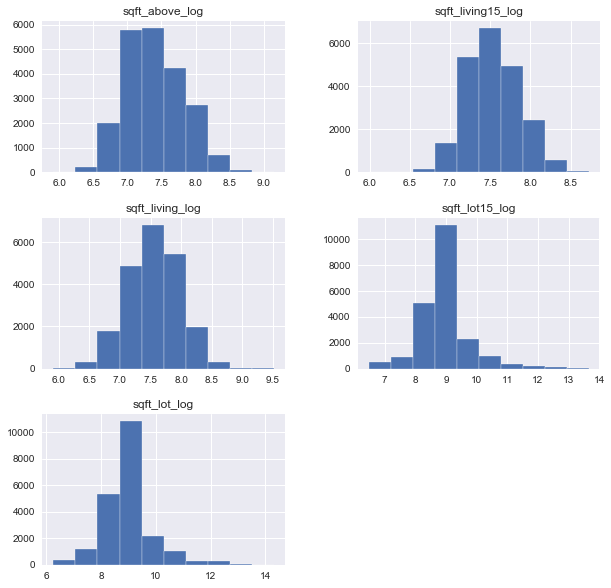

In [836]:
#as we can see log transform works just fine :)
data_log.hist(figsize = (10,10));

In [837]:
except_price = ['sqft_living_log', 'sqft_lot_log', 'sqft_above_log',
       'sqft_living15_log', 'sqft_lot15_log']

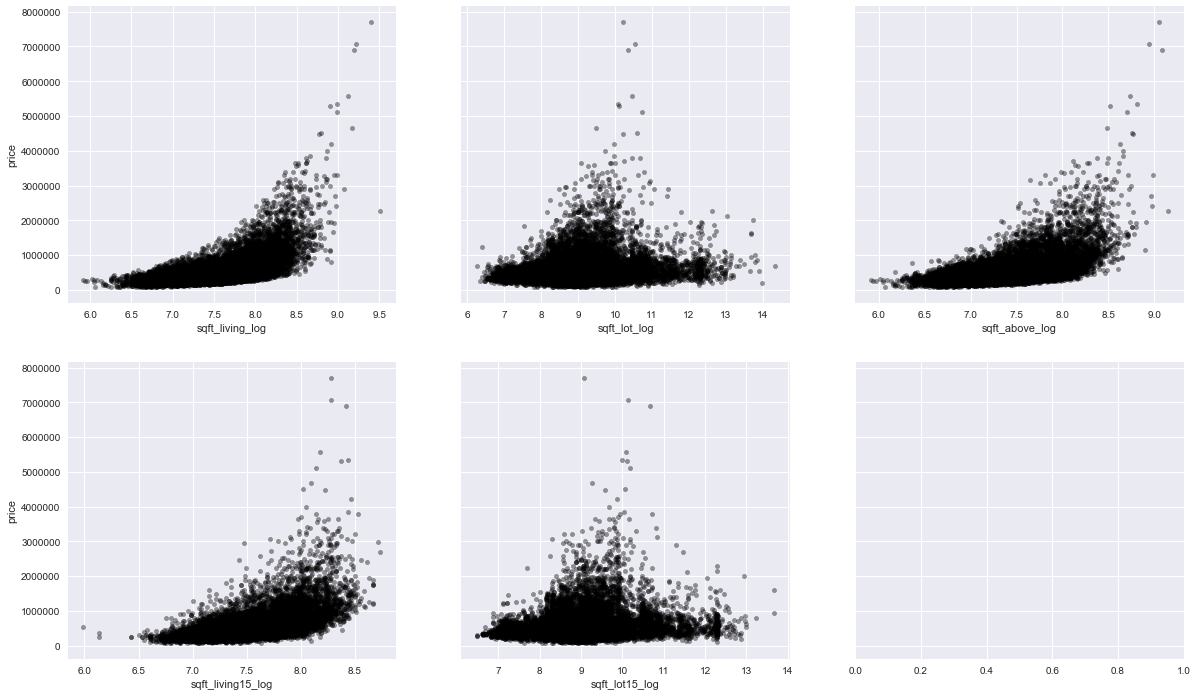

In [838]:
#compare log_data variables with normal price
data_log['price'] = df['price']
fig, axes = plt.subplots(nrows=2,ncols=3,sharey=True, figsize=(20,12))
for col,ax in zip(except_price,axes.flatten()):
    data_log.plot(kind='scatter', x=col,y='price',ax=ax, alpha=0.4, color='black')

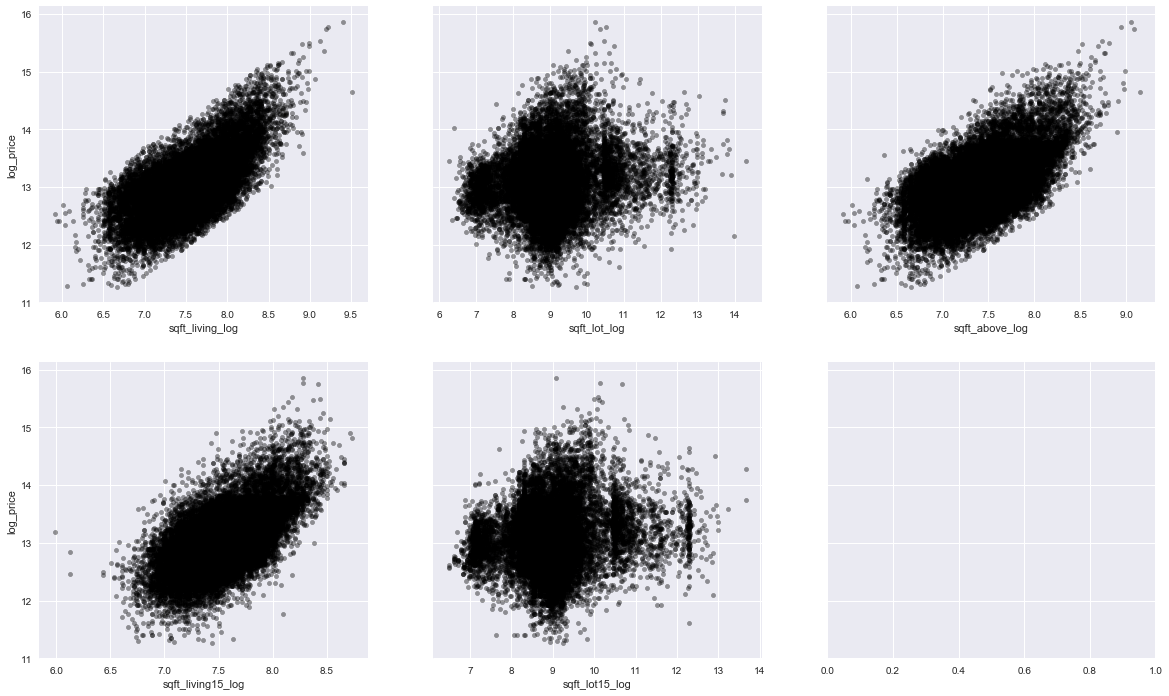

In [839]:
#compare log_data variables with log_price
data_log['log_price'] = df['price'].map(lambda x: np.log(x))
fig, axes = plt.subplots(nrows=2,ncols=3,sharey=True, figsize=(20,12))
for col,ax in zip(except_price,axes.flatten()):
    data_log.plot(kind='scatter', x=col,y='log_price',ax=ax, alpha=0.4, color='black')

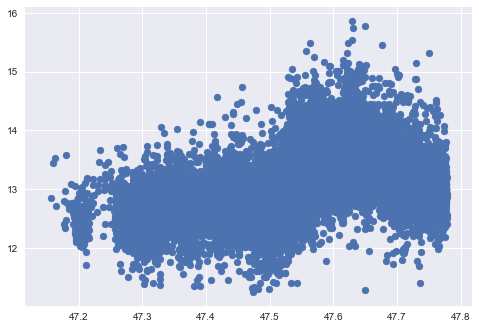

In [840]:
plt.scatter(x=df.lat,y=data_log.log_price);

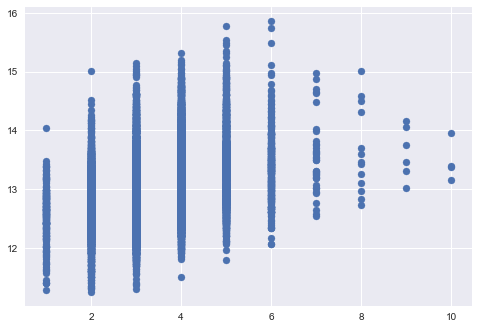

In [841]:
plt.scatter(x=df.bedrooms,y=data_log.log_price);

In [842]:
def standardize(series):
    scaled_series = (series - np.mean(series)) / np.std(series)
    return scaled_series

In [843]:
def normalization(series):
    scaled_series = (series - np.mean(series)) / (np.max(series) - np.min(series))
    return scaled_series

In [844]:
data_log_scaled = pd.DataFrame([])
data_log_scaled['sqft_lot_log_scaled']= standardize(data_log['sqft_lot_log'])
data_log_scaled['sqft_lot15_log_scaled']= standardize(data_log['sqft_lot15_log'])

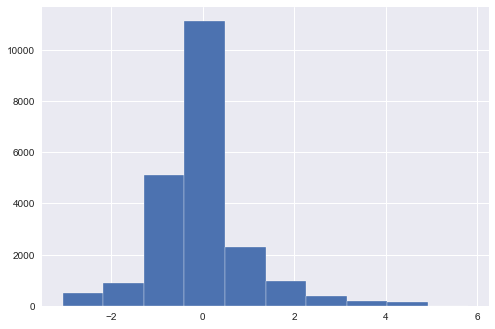

In [845]:
data_log_scaled['sqft_lot15_log_scaled'].hist();

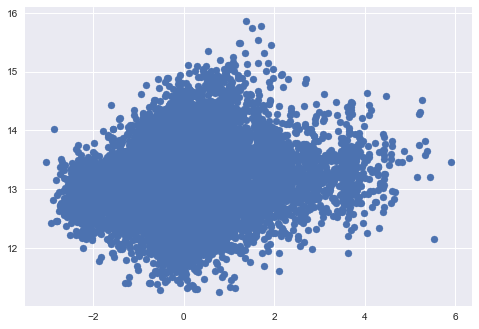

In [846]:
plt.scatter(x=data_log_scaled.sqft_lot_log_scaled,y=data_log.log_price);

In [847]:
gooz = normalization(data_log['sqft_lot_log'])

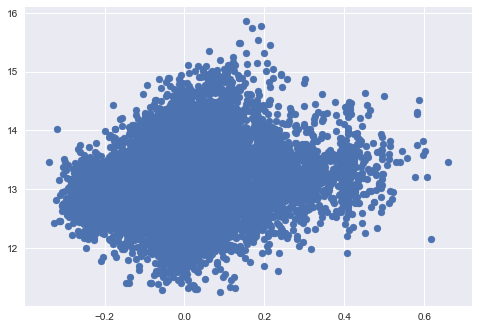

In [848]:
plt.scatter(x=gooz,y=data_log.log_price);

## Multiple Linear Regression in statsmodel

In [849]:
#this is the very first model for our cleaned data 
target = 'price'
predictors = df.drop('price',axis=1)
sum_predictors = '+'.join(predictors.columns)
formula = target + "~" + sum_predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.691
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     2681.
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:34:40   Log-Likelihood:            -2.9471e+05
No. Observations:               21597   AIC:                         5.895e+05
Df Residuals:                   21578   BIC:                         5.896e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -9.082e+07   9.57e+06     -9.494      0.000    -1.1e+08   -7.21e+07
date_sold       121.6103     12.341      9.854      0.000      97.422     145.799
bedrooms      -3.995e+04   2002.071    -19.952      0.000   -4.39e+04    -3.6e+04
bathrooms      1.684e+04   2807.982      5.998      0.000    1.13e+04    2.23e+04
sqft_living     185.5559      5.987     30.994      0.000     173.821     197.290
sqft_lot          0.1693      0.049      3.481      0.001       0.074       0.265
floors         1.477e+04   3738.220      3.951      0.000    7440.833    2.21e+04
waterfront     7.766e+05   1.72e+04     45.062      0.000    7.43e+05     8.1e+05
sqft_above        6.2151      6.557      0.948      0.343      -6.637      19.067
yr_built      -2647.1987     75.489    -35.067      0.000   -2795.163   -2499.235
zipcode        -514.1594     33.354    -15.415      0.000    -579.536    -448.783
lat            5.816e+05   1.09e+04     53.521      0.000     5.6e+05    6.03e+05
long          -2.369e+05   1.34e+04    -17.705      0.000   -2.63e+05   -2.11e+05
sqft_living15    33.7809      3.448      9.797      0.000      27.022      40.540
sqft_lot15       -0.3994      0.074     -5.362      0.000      -0.545      -0.253
basement      -3368.4258   5127.408     -0.657      0.511   -1.34e+04    6681.673
renovated      6.093e+04   8055.732      7.564      0.000    4.51e+04    7.67e+04
res_condition  3.009e+04   2385.697     12.614      0.000    2.54e+04    3.48e+04
res_grade       1.03e+05   2190.527     47.007      0.000    9.87e+04    1.07e+05
==============================================================================
Omnibus:                    18115.357   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1702424.544
Skew:                           3.510   Prob(JB):                         0.00
Kurtosis:                      45.925   Cond. No.                     5.11e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [850]:
df_preprocessed.columns

Index(['date_sold', 'price', 'sqft_living', 'sqft_lot', 'sqft_above',
       'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'bedrooms_2', 'bedrooms_3', 'bedrooms_4', 'bedrooms_5', 'bedrooms_6',
       'bedrooms_7', 'bedrooms_8', 'bedrooms_9', 'bedrooms_10', 'bathrooms_2',
       'bathrooms_3', 'bathrooms_4', 'bathrooms_5', 'bathrooms_6',
       'bathrooms_7', 'bathrooms_8', 'floors_2', 'floors_3', 'waterfront_1',
       'res_condition_1', 'res_condition_2', 'res_condition_3',
       'res_condition_4', 'res_grade_1', 'res_grade_2', 'res_grade_3',
       'res_grade_4', 'res_grade_5', 'res_grade_6', 'res_grade_7',
       'res_grade_8', 'res_grade_9', 'res_grade_10', 'basement_1',
       'renovated_1'],
      dtype='object')

In [851]:
def col_formatting(col):
    col = col.replace('.','_')
    return col

In [852]:
df_preprocessed.columns = [col_formatting(col) for col in df_preprocessed.columns]

In [853]:
#second model by considering ohe(categorical variables except zipcode)
target = 'price'
predictors = df_preprocessed.drop('price',axis=1)
sum_predictors = '+'.join(predictors.columns)
formula = target + "~" + sum_predictors
model = ols(formula=formula, data=df_preprocessed).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     1288.
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:34:40   Log-Likelihood:            -2.9329e+05
No. Observations:               21597   AIC:                         5.867e+05
Df Residuals:                   21551   BIC:                         5.870e+05
Df Model:                          45                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -8.206e+07   8.99e+06     -9.132      0.000   -9.97e+07   -6.44e+07
date_sold         116.7693     11.572     10.090      0.000      94.086     139.452
sqft_living       136.3913      5.764     23.663      0.000     125.093     147.689
sqft_lot            0.1493      0.046      3.269      0.001       0.060       0.239
sqft_above         -2.2243      6.326     -0.352      0.725     -14.623      10.175
yr_built        -2163.2553     72.660    -29.772      0.000   -2305.675   -2020.836
zipcode          -538.9086     31.526    -17.094      0.000    -600.702    -477.115
lat              5.866e+05   1.03e+04     56.915      0.000    5.66e+05    6.07e+05
long            -2.084e+05   1.27e+04    -16.431      0.000   -2.33e+05   -1.84e+05
sqft_living15      47.7653      3.311     14.425      0.000      41.275      54.256
sqft_lot15         -0.4208      0.070     -6.018      0.000      -0.558      -0.284
bedrooms_2       9443.4692   1.45e+04      0.650      0.516    -1.9e+04    3.79e+04
bedrooms_3      -1.176e+04   1.45e+04     -0.809      0.419   -4.03e+04    1.67e+04
bedrooms_4      -4.232e+04   1.49e+04     -2.849      0.004   -7.14e+04   -1.32e+04
bedrooms_5      -3.914e+04   1.56e+04     -2.502      0.012   -6.98e+04   -8473.338
bedrooms_6      -8.078e+04   1.91e+04     -4.225      0.000   -1.18e+05   -4.33e+04
bedrooms_7      -1.696e+05   3.51e+04     -4.837      0.000   -2.38e+05   -1.01e+05
bedrooms_8       5.344e+04   5.55e+04      0.963      0.336   -5.53e+04    1.62e+05
bedrooms_9      -4.571e+05   8.18e+04     -5.589      0.000   -6.17e+05   -2.97e+05
bedrooms_10     -1.596e+05   9.71e+04     -1.643      0.100    -3.5e+05    3.07e+04
bathrooms_2      2696.4773   4655.304      0.579      0.562   -6428.263    1.18e+04
bathrooms_3      6710.2095   6020.923      1.114      0.265   -5091.246    1.85e+04
bathrooms_4      8.237e+04   9338.572      8.820      0.000    6.41e+04    1.01e+05
bathrooms_5      2.384e+05   1.81e+04     13.190      0.000    2.03e+05    2.74e+05
bathrooms_6      5.744e+05    4.5e+04     12.774      0.000    4.86e+05    6.62e+05
bathrooms_7      1.149e+05   9.81e+04      1.172      0.241   -7.73e+04    3.07e+05
bathrooms_8       1.66e+06   1.05e+05     15.800      0.000    1.45e+06    1.87e+06
floors_2         2.903e+04   4181.478      6.942      0.000    2.08e+04    3.72e+04
floors_3         8.644e+04   9137.059      9.460      0.000    6.85e+04    1.04e+05
waterfront_1     7.452e+05   1.62e+04     45.943      0.000    7.13e+05    7.77e+05
res_condition_1  4.786e+04   3.86e+04      1.239      0.215   -2.78e+04    1.24e+05
res_condition_2  6.153e+04   3.59e+04      1.713      0.087   -8881.782    1.32e+05
res_condition_3  9.509e+04   3.59e+04      2.646      0.008    2.47e+04    1.66e+05
res_condition_4  1.457e+05   3.61e+04      4.032      0.000

In [854]:
df_preprocessed_zip.columns = [col_formatting(col) for col in df_preprocessed_zip.columns]

In [855]:
#model after considering zipcode as ctegorical
#it shows us that the more feature we have the more our R-squared will be
target = 'price'
predictors = df_preprocessed_zip.drop('price',axis=1)
sum_predictors = '+'.join(predictors.columns)
formula = target + "~" + sum_predictors
model = ols(formula=formula, data=df_preprocessed_zip).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     932.9
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:34:41   Log-Likelihood:            -2.8821e+05
No. Observations:               21597   AIC:                         5.767e+05
Df Residuals:                   21483   BIC:                         5.776e+05
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -1.26e+08   8.89e+06    -14.179      0.000   -1.43e+08   -1.09e+08
date_sold         122.8717      9.182     13.382      0.000     104.874     140.869
sqft_living       144.5704      4.590     31.499      0.000     135.574     153.567
sqft_lot            0.2690      0.036      7.411      0.000       0.198       0.340
sqft_above         13.2534      5.052      2.623      0.009       3.351      23.156
yr_built         -230.3832     64.456     -3.574      0.000    -356.722    -104.044
lat               1.76e+05   5.99e+04      2.940      0.003    5.87e+04    2.93e+05
long            -2.266e+05   4.31e+04     -5.259      0.000   -3.11e+05   -1.42e+05
sqft_living15      37.1417      2.738     13.563      0.000      31.774      42.509
sqft_lot15         -0.1758      0.057     -3.075      0.002      -0.288      -0.064
bedrooms_2       6537.3435   1.15e+04      0.567      0.571   -1.61e+04    2.91e+04
bedrooms_3       1.341e+04   1.16e+04      1.160      0.246   -9255.350    3.61e+04
bedrooms_4      -8894.5791   1.18e+04     -0.753      0.452   -3.21e+04    1.43e+04
bedrooms_5      -2.116e+04   1.25e+04     -1.699      0.089   -4.56e+04    3250.590
bedrooms_6      -4.271e+04   1.52e+04     -2.809      0.005   -7.25e+04   -1.29e+04
bedrooms_7      -1.623e+05   2.78e+04     -5.830      0.000   -2.17e+05   -1.08e+05
bedrooms_8      -3.616e+04   4.41e+04     -0.821      0.412   -1.23e+05    5.02e+04
bedrooms_9      -4.517e+05    6.5e+04     -6.950      0.000   -5.79e+05   -3.24e+05
bedrooms_10     -2.439e+05    7.7e+04     -3.168      0.002   -3.95e+05    -9.3e+04
bathrooms_2     -9063.9248   3706.156     -2.446      0.014   -1.63e+04   -1799.584
bathrooms_3     -5350.5023   4799.767     -1.115      0.265   -1.48e+04    4057.399
bathrooms_4      3.171e+04   7443.349      4.261      0.000    1.71e+04    4.63e+04
bathrooms_5      1.527e+05   1.44e+04     10.629      0.000    1.25e+05    1.81e+05
bathrooms_6      3.938e+05   3.57e+04     11.022      0.000    3.24e+05    4.64e+05
bathrooms_7      6.892e+04   7.78e+04      0.886      0.375   -8.35e+04    2.21e+05
bathrooms_8      1.359e+06   8.34e+04     16.286      0.000     1.2e+06    1.52e+06
floors_2        -1.628e+04   3473.838     -4.688      0.000   -2.31e+04   -9475.160
floors_3        -5.407e+04   7812.954     -6.921      0.000   -6.94e+04   -3.88e+04
waterfront_1     8.154e+05   1.31e+04     62.320      0.000     7.9e+05    8.41e+05
res_condition_1  8.101e+04   3.06e+04      2.644      0.008     2.1e+04    1.41e+05
res_condition_2  9.355e+04   2.85e+04      3.281      0.001    3.77e+04    1.49e+05
res_condition_3  1.231e+05   2.85e+04      4.315      0.000    6.72e+04    1.79e+05
res_condition_4  1.719e+05   2.87e+04      5.988      0.000    1.16e+05    2.28e+05
res_grade_1     -7.562e+04   1.55e+05     -0.488      0.625

our R-squred is relatively high but it doesn't mean that we have a well fitted model because there are still
variables that have multicolinearity with each other, and some other have insignificant p-values, which should
get eliminated.


In [856]:
#create a new dataframe for our base model


# df_base_model = df_preprocessed_zip.drop(columns= ['date_sold','yr_built','sqft_lot15',
#                                                   'sqft_living15','sqft_above'], axis=1)

In [857]:
# target = 'price'
# predictors = df_base_model.drop('price',axis=1)
# sum_predictors = '+'.join(predictors.columns)
# formula = target + "~" + sum_predictors
# model = ols(formula=formula, data=df_base_model).fit()
# model.summary()

The condition number is large, 2.48e+08. This might indicate that there are
strong multicollinearity

In [858]:
# df_base_model_corr = df_base_model.corr().abs().stack().reset_index().sort_values(0,ascending=False)
# df_base_model_corr['pairs'] = list(zip(df_base_model_corr.level_0,df_base_model_corr.level_1))
# df_base_model_corr.set_index(['pairs'],inplace=True)
# df_base_model_corr.drop(columns=['level_0','level_1'],inplace=True)
# df_base_model_corr.columns = ['Correlation']
# df_base_model_corr.drop_duplicates(inplace=True)
# df_base_model_corr[(df_base_model_corr.Correlation>.6)&(df_base_model_corr.Correlation<1)]


In [859]:
# df_base_model_revise = df_base_model.drop(columns= ['res_condition_2'], axis=1)

In [860]:
# target = 'price'
# predictors = df_base_model_revise.drop('price',axis=1)
# sum_predictors = '+'.join(predictors.columns)
# formula = target + "~" + sum_predictors
# model = ols(formula=formula, data=df_base_model_revise).fit()
# model.summary()

## Regression Model Validation with Train-Test-Split

In [861]:
y = df_preprocessed_zip[['price']]
x = df_preprocessed_zip.drop(['price'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=52)


In [862]:
print(len(x_train), len(x_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [863]:
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [864]:
x_train.head()

const  date_sold  sqft_living  sqft_lot  sqft_above  yr_built      lat  \
15476    1.0     735534         1210      7040        1210      1952  47.7450   
13427    1.0     735464         2120      9297        2120      1981  47.5561   
20387    1.0     735407         1270      2356        1270      2012  47.5671   
4244     1.0     735712         2680      4548        2680      2009  47.7073   
12520    1.0     735662         1380      3225         940      1915  47.6652   

          long  sqft_living15  sqft_lot15  ...  zipcode_98146  zipcode_98148  \
15476 -122.297           1210        7205  ...              0              0   
13427 -122.154           2620       10352  ...              0              0   
20387 -122.298           1490        2175  ...              0              0   
4244  -122.114           2750        4548  ...              0              0   
12520 -122.338           1250        3750  ...              0              0   

       zipcode_98155  zipcode_98166  zipcode_98168  zipcode_98177  \
15476              1              0              0              0   
13427              0              0              0              0   
20387              0              0              0              0   
4244               0              0              0              0   
12520              0              0              0              0   

       zipcode_98178  zipcode_98188  zipcode_98198  zipcode_98199  
15476              0              0              0              0  
13427              0              0              0              0  
20387              0              0              0              0  
4244               0              0              0              0  
12520              0              0              0              0  

[5 rows x 114 columns]

In [865]:
x_test.head()

const  date_sold  sqft_living  sqft_lot  sqft_above  yr_built      lat  \
3189     1.0     735500         1720      6413         860      1950  47.5734   
16967    1.0     735653         1030     12700        1030      1944  47.3877   
12383    1.0     735725         1780     10260        1780      1971  47.6647   
14947    1.0     735437         3920      7200        3120      1928  47.5731   
14343    1.0     735575         3510     10930        3510      2013  47.6914   

          long  sqft_living15  sqft_lot15  ...  zipcode_98146  zipcode_98148  \
3189  -122.395           1280        6413  ...              0              0   
16967 -122.236           1140        6955  ...              0              0   
12383 -122.142           2360       10080  ...              0              0   
14947 -122.284           3400        7200  ...              0              0   
14343 -122.210           1970        7488  ...              0              0   

       zipcode_98155  zipcode_98166  zipcode_98168  zipcode_98177  \
3189               0              0              0              0   
16967              0              0              0              0   
12383              0              0              0              0   
14947              0              0              0              0   
14343              0              0              0              0   

       zipcode_98178  zipcode_98188  zipcode_98198  zipcode_98199  
3189               0              0              0              0  
16967              0              0              0              0  
12383              0              0              0              0  
14947              0              0              0              0  
14343              0              0              0              0  

[5 rows x 114 columns]

In [866]:
linreg = LinearRegression()
linreg.fit(x_train,y_train)

y_hat_train = linreg.predict(x_train)
y_hat_test = linreg.predict(x_test)

In [867]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [868]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Root Mean Squarred Error:', train_mse**0.5)
print('Test Root Mean Squarred Error:', test_mse**0.5)

Train Root Mean Squarred Error: 151604.47014341614
Test Root Mean Squarred Error: 150836.00244518134


In [869]:
target = 'price'
predictors = '+'.join(x_train.columns)
train = pd.concat([x_train,y_train], axis=1)
formula = target + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     759.4
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:34:41   Log-Likelihood:            -2.3061e+05
No. Observations:               17277   AIC:                         4.615e+05
Df Residuals:                   17163   BIC:                         4.623e+05
Df Model:                         113                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -6.461e+07   5.05e+06    -12.798      0.000   -7.45e+07   -5.47e+07
const           -6.461e+07   5.05e+06    -12.798      0.000   -7.45e+07   -5.47e+07
date_sold         119.6748     10.312     11.606      0.000      99.463     139.886
sqft_living       143.5803      5.135     27.959      0.000     133.515     153.646
sqft_lot            0.3044      0.040      7.651      0.000       0.226       0.382
sqft_above         15.3454      5.691      2.696      0.007       4.190      26.501
yr_built         -246.3908     72.613     -3.393      0.001    -388.719    -104.063
lat              1.706e+05   6.71e+04      2.543      0.011    3.91e+04    3.02e+05
long            -2.743e+05   5.01e+04     -5.471      0.000   -3.73e+05   -1.76e+05
sqft_living15      37.9653      3.094     12.273      0.000      31.902      44.029
sqft_lot15         -0.2158      0.065     -3.300      0.001      -0.344      -0.088
bedrooms_2        859.9387   1.28e+04      0.067      0.947   -2.43e+04     2.6e+04
bedrooms_3       6632.7421   1.29e+04      0.516      0.606   -1.86e+04    3.18e+04
bedrooms_4      -1.691e+04   1.32e+04     -1.286      0.199   -4.27e+04    8868.744
bedrooms_5      -2.893e+04   1.39e+04     -2.083      0.037   -5.62e+04   -1711.446
bedrooms_6      -6.097e+04    1.7e+04     -3.597      0.000   -9.42e+04   -2.77e+04
bedrooms_7      -2.025e+05   3.09e+04     -6.557      0.000   -2.63e+05   -1.42e+05
bedrooms_8      -5.053e+04   5.03e+04     -1.005      0.315   -1.49e+05     4.8e+04
bedrooms_9      -4.475e+05   6.57e+04     -6.815      0.000   -5.76e+05   -3.19e+05
bedrooms_10     -3.125e+05   8.92e+04     -3.502      0.000   -4.87e+05   -1.38e+05
bathrooms_2     -7846.9146   4166.269     -1.883      0.060    -1.6e+04     319.399
bathrooms_3     -5221.0789   5390.571     -0.969      0.333   -1.58e+04    5344.991
bathrooms_4      4.434e+04   8367.551      5.299      0.000    2.79e+04    6.07e+04
bathrooms_5      1.493e+05   1.62e+04      9.227      0.000    1.18e+05    1.81e+05
bathrooms_6      3.871e+05   4.09e+04      9.472      0.000    3.07e+05    4.67e+05
bathrooms_7      2.813e+05   9.02e+04      3.119      0.002    1.04e+05    4.58e+05
bathrooms_8      1.261e+06   8.55e+04     14.743      0.000    1.09e+06    1.43e+06
floors_2        -1.889e+04   3898.983     -4.844      0.000   -2.65e+04   -1.12e+04
floors_3        -5.679e+04   8795.914     -6.456      0.000    -7.4e+04   -3.95e+04
waterfront_1      8.32e+05   1.42e+04     58.533      0.000    8.04e+05     8.6e+05
res_condition_1  7.683e+04   3.34e+04      2.302      0.021    1.14e+04    1.42e+05
res_condition_2  8.681e+04   3.09e+04      2.810      0.005    2.63e+04    1.47e+05
res_condition_3  1.169e+05   3.09e+04      3.783      0.000    5.64e+04    1.78e+05
res_condition_4  1.605e+05   3.11e+04      5.160      0.000

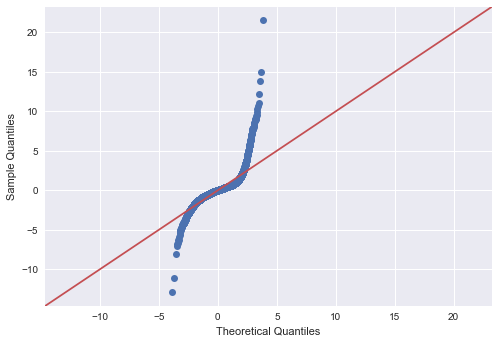

In [870]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

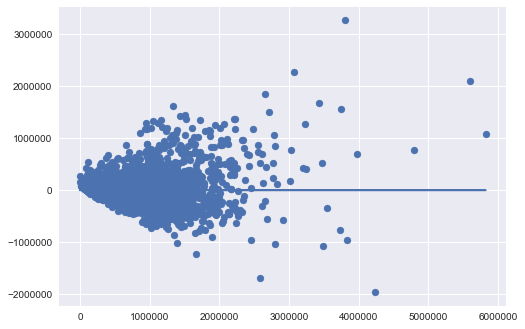

In [871]:
plt.scatter(model.predict(x_train), model.resid)
plt.plot(model.predict(x_train), [0 for i in range(len(x_train))]);

In [872]:
#create a dataframe that contains only 2 standard deviation of price
df_AP_1 = df_preprocessed_zip[(np.abs(stats.zscore(df_preprocessed_zip.price)) < 2)]
df_AP_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20756 entries, 0 to 21596
Columns: 114 entries, date_sold to zipcode_98199
dtypes: float64(3), int64(7), uint8(104)
memory usage: 3.8 MB


In [873]:
#our price range is now from 78,000 to 1,270,000
df_AP_1.price.describe()

count    2.075600e+04
mean     4.877262e+05
std      2.244543e+05
min      7.800000e+04
25%      3.170000e+05
50%      4.400000e+05
75%      6.132750e+05
max      1.270000e+06
Name: price, dtype: float64

In [874]:
q4 = df_AP_1[(df_AP_1.price >= 613275)]

In [875]:
q3 = df_AP_1[(df_AP_1.price >= 440000) & (df_AP_1.price < 613275)]

In [876]:
q2 = df_AP_1[(df_AP_1.price >= 317000) & (df_AP_1.price < 440000)]

In [877]:
q1 = df_AP_1[(df_AP_1.price >= 78000) & (df_AP_1.price < 317000)]
q1.price.describe()

count      5184.000000
mean     248862.825810
std       47139.082165
min       78000.000000
25%      219950.000000
50%      255000.000000
75%      286000.000000
max      316750.000000
Name: price, dtype: float64

In [878]:
y = df_AP_1[['price']]
x = df_AP_1.drop(['price'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=52)

print(len(x_train), len(x_test), len(y_train), len(y_test))

16604 4152 16604 4152


In [879]:
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [880]:
linreg.fit(x_train,y_train)

y_hat_train = linreg.predict(x_train)
y_hat_test = linreg.predict(x_test)
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [881]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Root Mean Squarred Error:', train_mse**0.5)
print('Test Root Mean Squarred Error:', test_mse**0.5)

Train Root Mean Squarred Error: 90721.57381726977
Test Root Mean Squarred Error: 93341.3877179127


In [882]:
target = 'price'
predictors = '+'.join(x_train.columns)
train = pd.concat([x_train,y_train], axis=1)
formula = target + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     756.6
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:34:44   Log-Likelihood:            -2.1310e+05
No. Observations:               16604   AIC:                         4.264e+05
Df Residuals:                   16491   BIC:                         4.273e+05
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -4.177e+07   3.03e+06    -13.768      0.000   -4.77e+07   -3.58e+07
const           -4.177e+07   3.03e+06    -13.768      0.000   -4.77e+07   -3.58e+07
date_sold          92.9580      6.304     14.746      0.000      80.602     105.314
sqft_living        77.2913      3.425     22.567      0.000      70.578      84.005
sqft_lot            0.3099      0.026     11.878      0.000       0.259       0.361
sqft_above         34.0975      3.757      9.075      0.000      26.733      41.462
yr_built         -432.0723     44.913     -9.620      0.000    -520.106    -344.039
lat              1.219e+05   4.11e+04      2.964      0.003    4.13e+04    2.02e+05
long             -8.34e+04   2.92e+04     -2.854      0.004   -1.41e+05   -2.61e+04
sqft_living15      40.9877      1.991     20.585      0.000      37.085      44.891
sqft_lot15         -0.0139      0.040     -0.344      0.731      -0.093       0.065
bedrooms_2       1.402e+04   7823.965      1.792      0.073   -1312.673    2.94e+04
bedrooms_3       2.137e+04   7855.665      2.720      0.007    5971.535    3.68e+04
bedrooms_4       1.722e+04   8038.306      2.142      0.032    1466.027     3.3e+04
bedrooms_5       6032.5161   8522.076      0.708      0.479   -1.07e+04    2.27e+04
bedrooms_6      -1.095e+04   1.07e+04     -1.024      0.306   -3.19e+04       1e+04
bedrooms_7      -5.404e+04   2.04e+04     -2.646      0.008   -9.41e+04    -1.4e+04
bedrooms_8      -5.607e+04   3.34e+04     -1.676      0.094   -1.22e+05    9493.758
bedrooms_9      -2120.0260   6.53e+04     -0.032      0.974    -1.3e+05    1.26e+05
bedrooms_10     -3.578e+04   4.65e+04     -0.769      0.442   -1.27e+05    5.55e+04
bathrooms_2      6287.8234   2506.296      2.509      0.012    1375.213    1.12e+04
bathrooms_3      1.782e+04   3286.802      5.422      0.000    1.14e+04    2.43e+04
bathrooms_4      4.242e+04   5355.442      7.920      0.000    3.19e+04    5.29e+04
bathrooms_5     -7258.9852   1.27e+04     -0.573      0.566   -3.21e+04    1.76e+04
bathrooms_6     -1.622e+05   5.48e+04     -2.958      0.003    -2.7e+05   -5.47e+04
bathrooms_7     -1.554e+05   6.62e+04     -2.349      0.019   -2.85e+05   -2.57e+04
bathrooms_8     -2.251e+05   1.12e+05     -2.009      0.045   -4.45e+05   -5484.407
floors_2        -1.435e+04   2411.931     -5.948      0.000   -1.91e+04   -9617.786
floors_3        -4.619e+04   5470.602     -8.444      0.000   -5.69e+04   -3.55e+04
waterfront_1     3.269e+05   1.31e+04     24.938      0.000    3.01e+05    3.53e+05
res_condition_1  6.294e+04   2.21e+04      2.853      0.004    1.97e+04    1.06e+05
res_condition_2  9.974e+04   2.07e+04      4.818      0.000    5.92e+04     1.4e+05
res_condition_3  1.216e+05   2.07e+04      5.871      0.000     8.1e+04    1.62e+05
res_condition_4  1.568e+05   2.08e+04      7.529      0.000

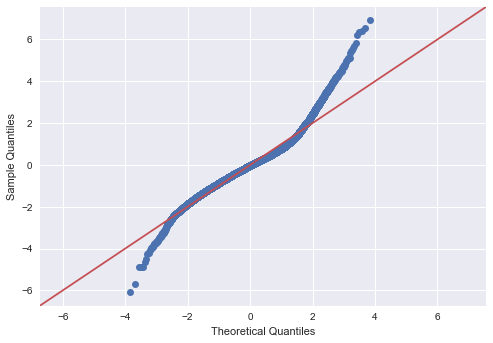

In [883]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

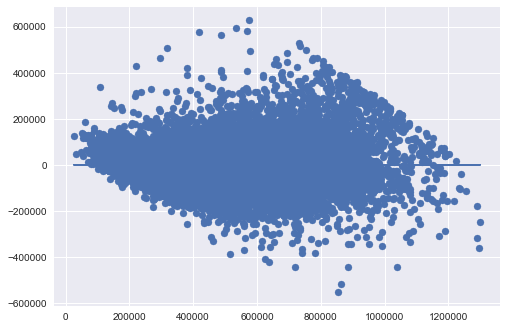

In [884]:
plt.scatter(model.predict(x_train), model.resid)
plt.plot(model.predict(x_train), [0 for i in range(len(x_train))]);

In [885]:
df_AP_2 = df_AP_1

In [886]:
df_AP_2.price = df_AP_1.price.apply(lambda x:np.log(x))

/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [887]:
y = df_AP_2[['price']]
x = df_AP_2.drop(['price'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=52)


x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

linreg.fit(x_train,y_train)

y_hat_train = linreg.predict(x_train)
y_hat_test = linreg.predict(x_test)
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(np.exp(y_train), np.exp(y_hat_train))
test_mse = mean_squared_error(np.exp(y_test), np.exp(y_hat_test))
print('Train Root Mean Squarred Error:', train_mse**0.5)
print('Test Root Mean Squarred Error:', test_mse**0.5)

Train Root Mean Squarred Error: 91217.61330312863
Test Root Mean Squarred Error: 92721.01104379889


/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [888]:
target = 'price'
predictors = '+'.join(x_train.columns)
train = pd.concat([x_train,y_train], axis=1)
formula = target + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     850.4
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:34:46   Log-Likelihood:                 5260.5
No. Observations:               16604   AIC:                        -1.030e+04
Df Residuals:                   16491   BIC:                            -9423.
Df Model:                         112                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -96.8178      5.895    -16.425      0.000    -108.372     -85.264
const             -96.8178      5.895    -16.425      0.000    -108.372     -85.264
date_sold           0.0002   1.22e-05     16.272      0.000       0.000       0.000
sqft_living         0.0001   6.65e-06     18.809      0.000       0.000       0.000
sqft_lot         6.777e-07   5.07e-08     13.370      0.000    5.78e-07    7.77e-07
sqft_above       9.127e-05    7.3e-06     12.503      0.000     7.7e-05       0.000
yr_built           -0.0008   8.73e-05     -8.905      0.000      -0.001      -0.001
lat                 0.4798      0.080      6.005      0.000       0.323       0.636
long               -0.3075      0.057     -5.417      0.000      -0.419      -0.196
sqft_living15    9.347e-05   3.87e-06     24.161      0.000    8.59e-05       0.000
sqft_lot15       1.591e-07   7.86e-08      2.025      0.043    5.09e-09    3.13e-07
bedrooms_2          0.0461      0.015      3.032      0.002       0.016       0.076
bedrooms_3          0.0584      0.015      3.827      0.000       0.029       0.088
bedrooms_4          0.0579      0.016      3.709      0.000       0.027       0.089
bedrooms_5          0.0313      0.017      1.893      0.058      -0.001       0.064
bedrooms_6          0.0011      0.021      0.052      0.959      -0.040       0.042
bedrooms_7         -0.0840      0.040     -2.116      0.034      -0.162      -0.006
bedrooms_8         -0.0792      0.065     -1.219      0.223      -0.207       0.048
bedrooms_9         -0.0447      0.127     -0.352      0.725      -0.293       0.204
bedrooms_10        -0.0321      0.090     -0.355      0.723      -0.209       0.145
bathrooms_2         0.0490      0.005     10.052      0.000       0.039       0.058
bathrooms_3         0.0825      0.006     12.915      0.000       0.070       0.095
bathrooms_4         0.0883      0.010      8.485      0.000       0.068       0.109
bathrooms_5        -0.0128      0.025     -0.520      0.603      -0.061       0.035
bathrooms_6        -0.2938      0.107     -2.758      0.006      -0.503      -0.085
bathrooms_7        -0.2242      0.129     -1.745      0.081      -0.476       0.028
bathrooms_8        -0.2959      0.218     -1.359      0.174      -0.723       0.131
floors_2           -0.0289      0.005     -6.159      0.000      -0.038      -0.020
floors_3           -0.1070      0.011    -10.069      0.000      -0.128      -0.086
waterfront_1        0.5843      0.025     22.940      0.000       0.534       0.634
res_condition_1     0.1201      0.043      2.801      0.005       0.036       0.204
res_condition_2     0.2781      0.040      6.914      0.000       0.199       0.357
res_condition_3     0.3235      0.040      8.040      0.000       0.245       0.402
res_condition_4     0.3825      0.040      9.455      0.000

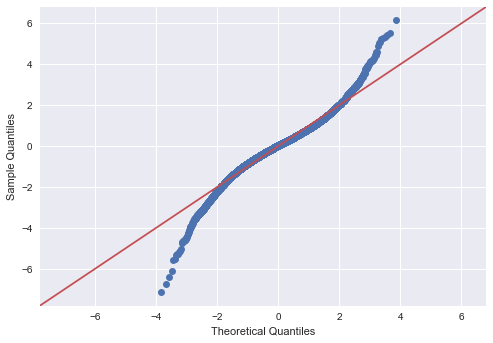

In [889]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

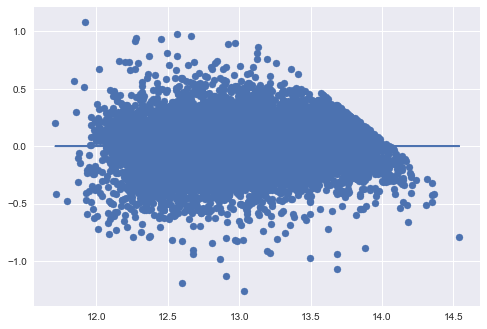

In [890]:
plt.scatter(model.predict(x_train), model.resid)
plt.plot(model.predict(x_train), [0 for i in range(len(x_train))]);

## Iterative process and shape of our data

In [891]:
df_p = df[(np.abs(stats.zscore(df.price)) < 2)]

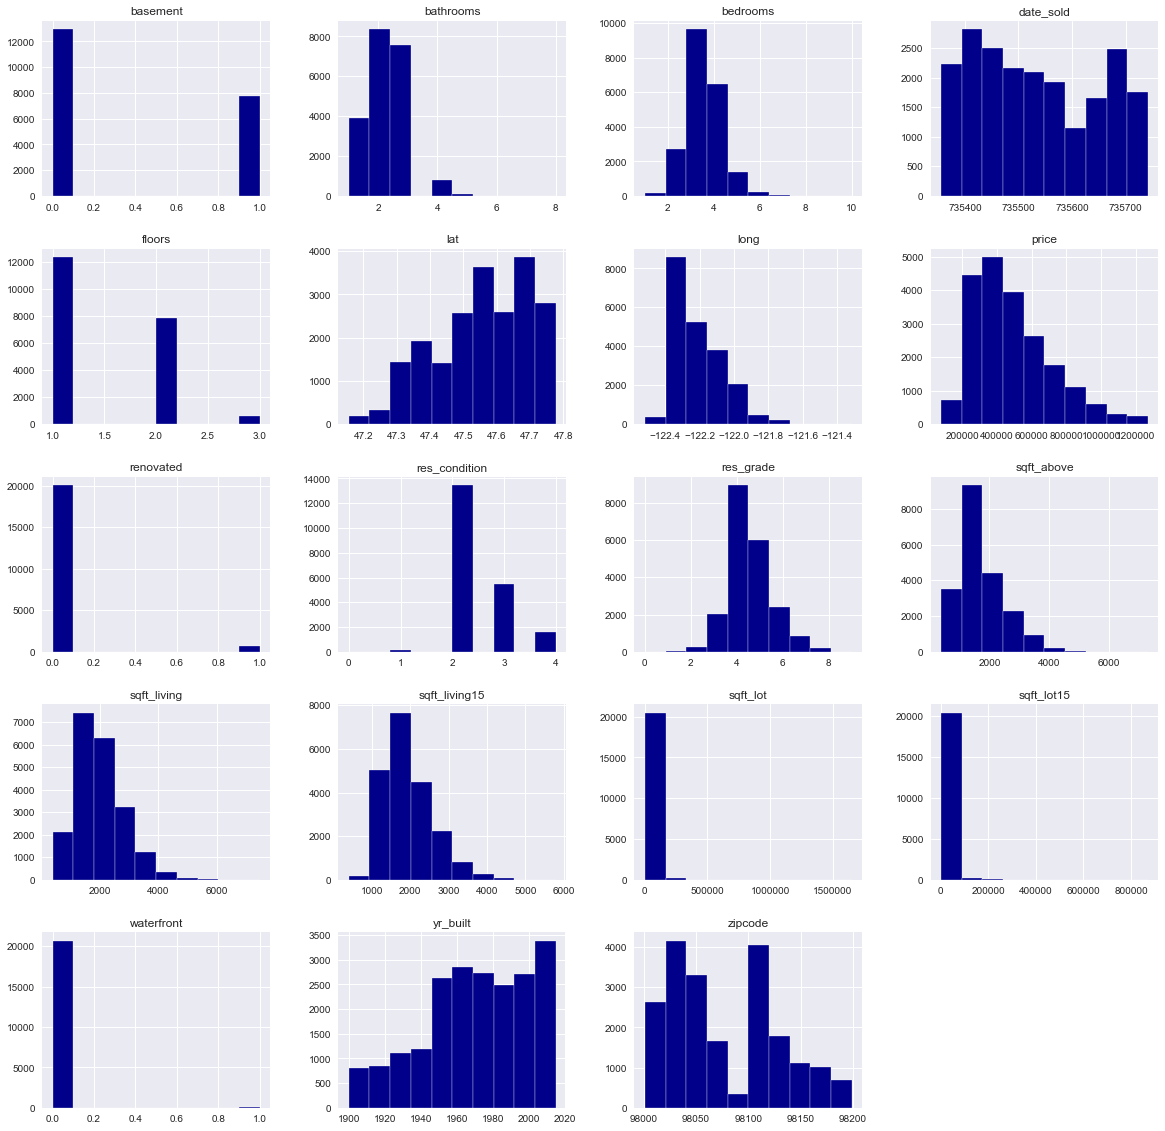

In [892]:
df_p.hist(figsize=(20,20),color='darkblue');

In [893]:
categoricals = ['bedrooms','bathrooms','floors','waterfront','res_condition','res_grade','basement','renovated']
continuous = ['date_sold','sqft_living','sqft_lot','sqft_above',
              'yr_built','zipcode','lat','long','sqft_living15','sqft_lot15']

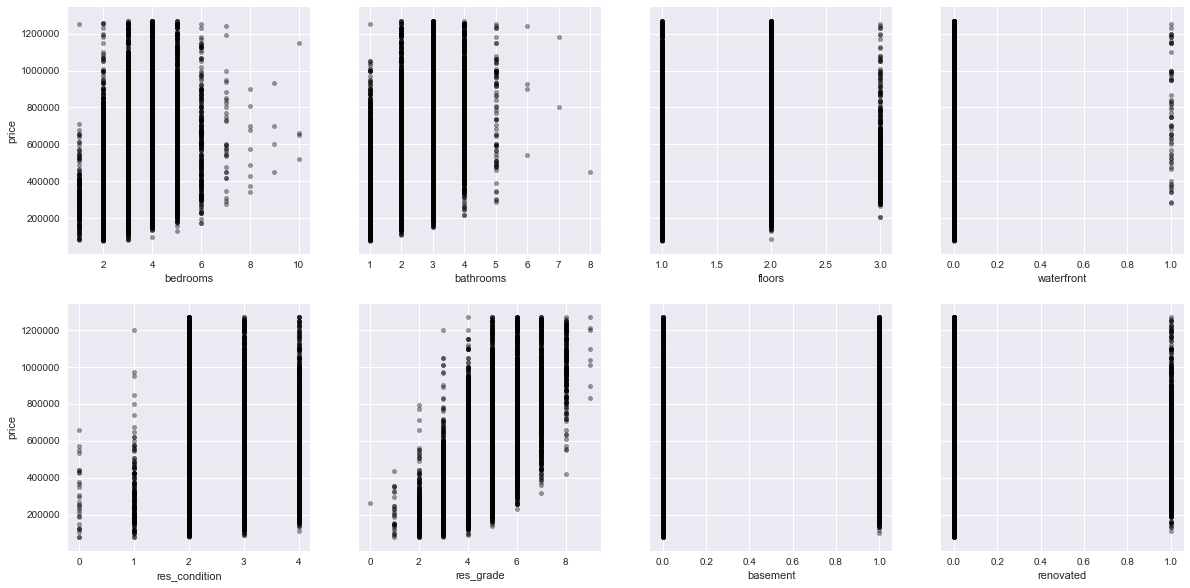

In [894]:
#to check our categoricals by scatter plot
fig, axes = plt.subplots(nrows=2,ncols=4,sharey=True, figsize=(20,10))
for col,ax in zip(categoricals,axes.flatten()):
    df_p.plot(kind='scatter', x=col,y='price',ax=ax, alpha=0.4, color='black')

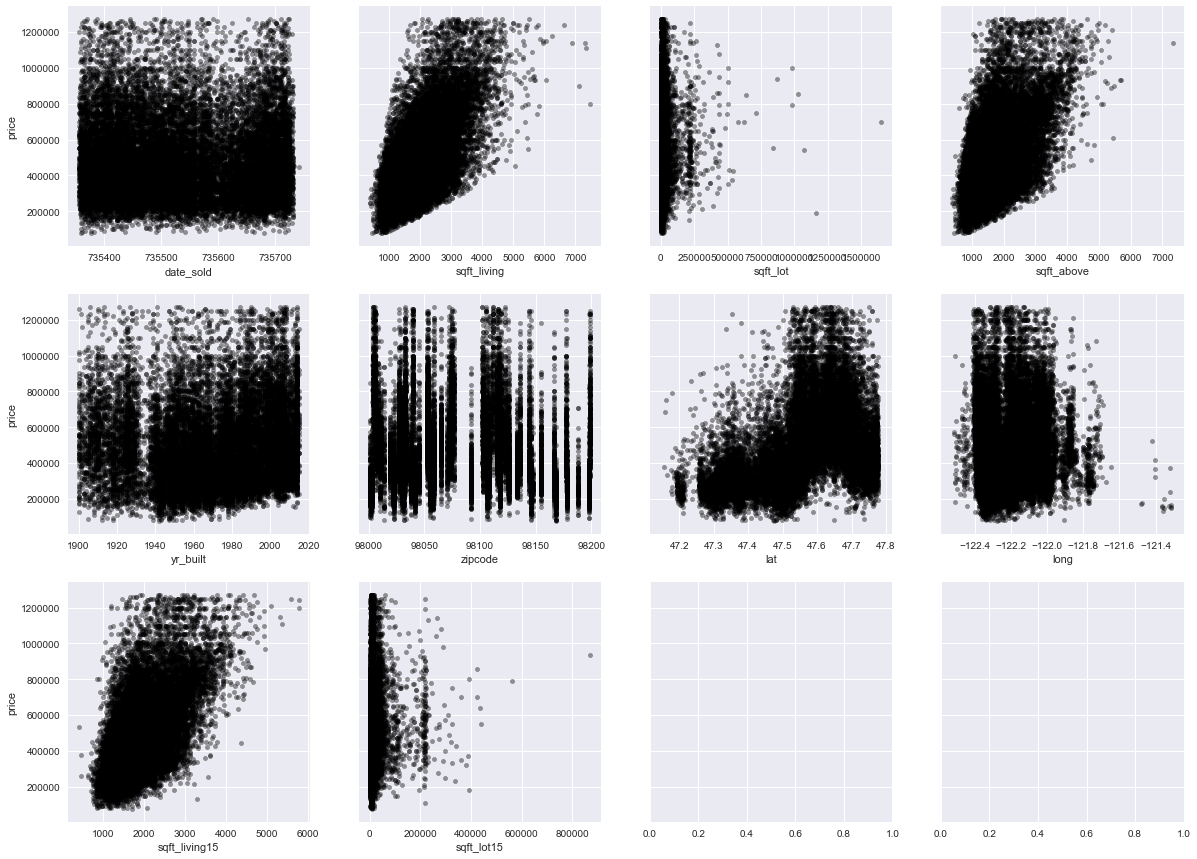

In [895]:
#to check our continuous variables bu scatter plots
#it seems that zipcodes are more looklile categorical variables but we want to consider them as continuous

fig, axes = plt.subplots(nrows=3,ncols=4,sharey=True, figsize=(20,15))
for col,ax in zip(continuous,axes.flatten()):
    df_p.plot(kind='scatter', x=col,y='price',ax=ax, alpha=0.4, color='black')

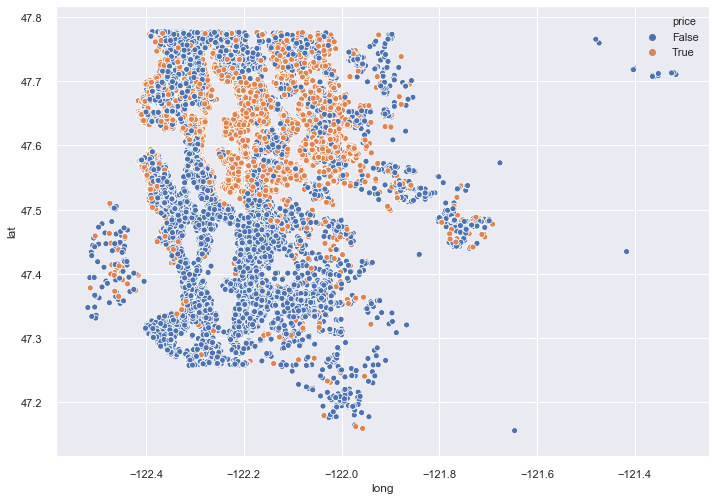

In [896]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.scatterplot(df.long,df.lat,hue=df.price >= 613275);

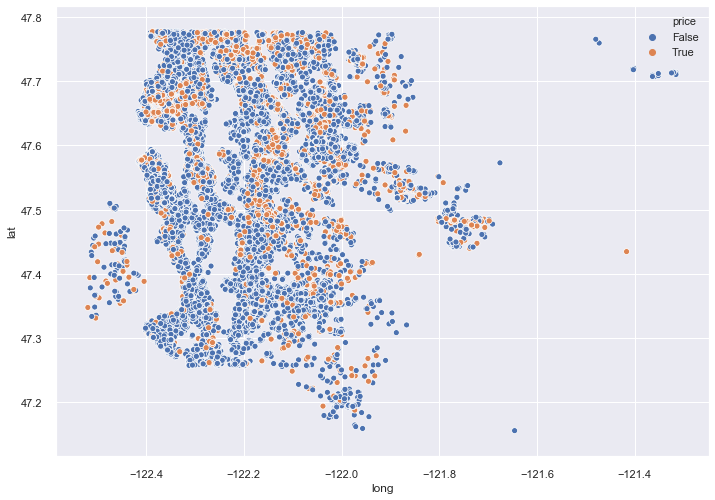

In [897]:
sns.scatterplot(df.long,df.lat,hue=(df_p.price >= 440000) & (df_p.price < 613275));

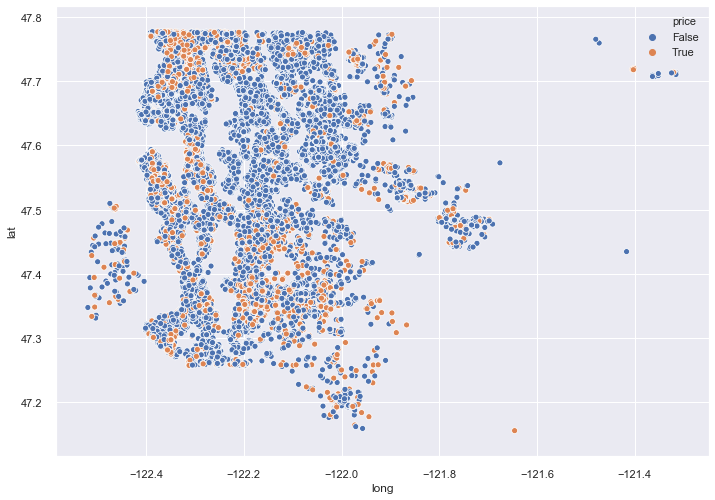

In [898]:
sns.scatterplot(df.long,df.lat,hue=((df_p.price >= 317000) & (df_p.price < 440000)));

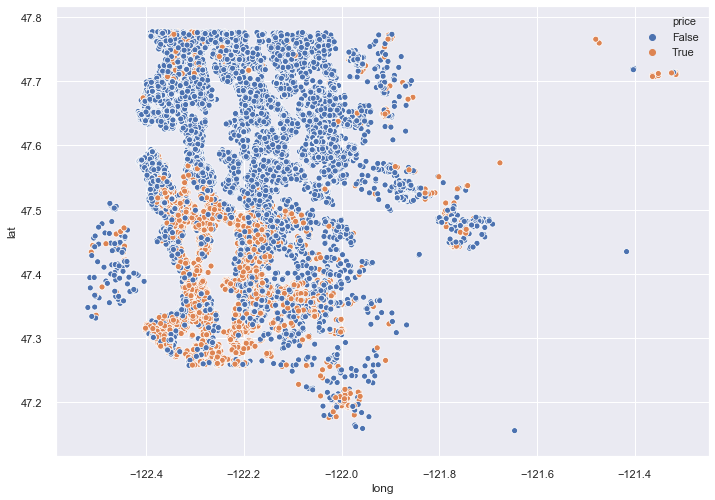

In [899]:
sns.scatterplot(df.long,df.lat,hue=(df_p.price < 317000));

In [900]:
def finding_location(df):
    if ((df.lat>47.52)&(df.long> -122.3)):
        y='NE'
    elif ((df.lat>47.52)&(df.long<= -122.3)):
        y='NW'
    elif ((df.lat<=47.52)&(df.long> -122.1)):
        y='SE'
    else:
        y='SW'
    return y

In [901]:
df_p['location'] = df_p.apply(finding_location, axis=1)

/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [902]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20756 entries, 0 to 21596
Data columns (total 20 columns):
date_sold        20756 non-null int64
price            20756 non-null float64
bedrooms         20756 non-null int64
bathrooms        20756 non-null int64
sqft_living      20756 non-null int64
sqft_lot         20756 non-null int64
floors           20756 non-null int64
waterfront       20756 non-null int64
sqft_above       20756 non-null int64
yr_built         20756 non-null int64
zipcode          20756 non-null int64
lat              20756 non-null float64
long             20756 non-null float64
sqft_living15    20756 non-null int64
sqft_lot15       20756 non-null int64
basement         20756 non-null int64
renovated        20756 non-null int64
res_condition    20756 non-null int64
res_grade        20756 non-null int64
location         20756 non-null object
dtypes: float64(3), int64(16), object(1)
memory usage: 4.0+ MB


In [903]:
df_p.head()

date_sold     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0     735519  221900.0         3          1         1180      5650       1   
1     735576  538000.0         3          2         2570      7242       2   
2     735654  180000.0         2          1          770     10000       1   
3     735576  604000.0         4          3         1960      5000       1   
4     735647  510000.0         3          2         1680      8080       1   

   waterfront  sqft_above  yr_built  zipcode      lat     long  sqft_living15  \
0           0        1180      1955    98178  47.5112 -122.257           1340   
1           0        2170      1951    98125  47.7210 -122.319           1690   
2           0         770      1933    98028  47.7379 -122.233           2720   
3           0        1050      1965    98136  47.5208 -122.393           1360   
4           0        1680      1987    98074  47.6168 -122.045           1800   

   sqft_lot15  basement  renovated  res_condition  res_grade location  
0        5650         0          0              2          4       SW  
1        7639         1          1              2          4       NW  
2        8062         0          0              2          3       NE  
3        5000         1          0              4          4       NW  
4        7503         0          0              2          5       NE

In [904]:
search = SearchEngine()

In [905]:
def find_city(x):
    city = search.by_zipcode(x).city 
    return city 

In [906]:
df['city'] = df['zipcode'].apply(find_city)

In [907]:
df_p['city'] = df_p['zipcode'].apply(find_city)

/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [908]:
df_p.city.value_counts()

Seattle          8653
Renton           1586
Kent             1201
Bellevue         1179
Redmond           960
Kirkland          914
Auburn            911
Federal Way       778
Sammamish         772
Issaquah          714
Maple Valley      588
Woodinville       463
Snoqualmie        307
Kenmore           282
Enumclaw          233
North Bend        218
Bothell           195
Mercer Island     193
Duvall            190
Carnation         121
Vashon            115
Black Diamond     100
Fall City          73
Medina             10
Name: city, dtype: int64

In [909]:
df_p.groupby('city')['price'].mean().sort_values(ascending=False).round(2)

city
Medina           1025500.00
Mercer Island     896602.93
Bellevue          706294.98
Sammamish         695734.20
Redmond           641122.76
Woodinville       601234.33
Issaquah          585356.52
Kirkland          564444.58
Snoqualmie        524840.30
Bothell           490377.11
Seattle           489313.89
Fall City         486844.79
Vashon            474153.88
Kenmore           458455.14
North Bend        428491.33
Carnation         426500.18
Duvall            424815.06
Black Diamond     423665.99
Renton            394709.41
Maple Valley      365419.87
Enumclaw          316742.39
Kent              299470.05
Auburn            291647.82
Federal Way       288118.02
Name: price, dtype: float64

In [910]:
df_p.city.nunique()

24

In [911]:
df_p['bathrooms']=df_p.bathrooms.apply(num_round).astype(int)

/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [912]:
def condition(x):
    if x <= 1:
        y = 'bad'
    else:
        y= 'good'
    return y
    

In [913]:
def cat_bath(x):
    if x==1:
        y='one'
    elif x==2:
        y='two'
    elif x==3:
        y='three'
    else:
        y='MoreThanThree'
    return y

In [914]:
# df_p['bathrooms']=df_p.bathrooms.apply(cat_bath)

In [915]:
# df_p['res_condition']=df_p.res_condition.apply(condition)

In [916]:
df_p['city'] = df_p.city.map(lambda x: x.replace(' ','_'))

/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [917]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20756 entries, 0 to 21596
Data columns (total 21 columns):
date_sold        20756 non-null int64
price            20756 non-null float64
bedrooms         20756 non-null int64
bathrooms        20756 non-null int64
sqft_living      20756 non-null int64
sqft_lot         20756 non-null int64
floors           20756 non-null int64
waterfront       20756 non-null int64
sqft_above       20756 non-null int64
yr_built         20756 non-null int64
zipcode          20756 non-null int64
lat              20756 non-null float64
long             20756 non-null float64
sqft_living15    20756 non-null int64
sqft_lot15       20756 non-null int64
basement         20756 non-null int64
renovated        20756 non-null int64
res_condition    20756 non-null int64
res_grade        20756 non-null int64
location         20756 non-null object
city             20756 non-null object
dtypes: float64(3), int64(16), object(2)
memory usage: 4.1+ MB


In in this part I try to change different kinds of categorical and continuous variables.
I also added feature "city" to realize that is it making any difference or not.
* feature name "sqft_lot15" is deleted because of no linearity with price.

In [918]:
categoricals = ['waterfront','res_condition','floors','bedrooms','city'
                ,'location','res_grade','basement','renovated','bathrooms']

continuous = ['sqft_living''yr_built','sqft_lot','sqft_above',
              'date_sold','sqft_living15','lat','long']

deleted = ['sqft_lot15','zipcode']

In [919]:
#Dealing with categorical variables by ohe
dummies = df_p[categoricals].astype('category')
dummies = pd.get_dummies(dummies,prefix=dummies.columns, drop_first=True)
df_preprocessed = df_p.drop(categoricals, axis=1)
df_preprocessed = pd.concat([df_preprocessed, dummies], axis=1)
df_preprocessed = df_preprocessed.drop(deleted, axis=1)
df_preprocessed.head()

date_sold     price  sqft_living  sqft_lot  sqft_above  yr_built      lat  \
0     735519  221900.0         1180      5650        1180      1955  47.5112   
1     735576  538000.0         2570      7242        2170      1951  47.7210   
2     735654  180000.0          770     10000         770      1933  47.7379   
3     735576  604000.0         1960      5000        1050      1965  47.5208   
4     735647  510000.0         1680      8080        1680      1987  47.6168   

      long  sqft_living15  waterfront_1  ...  res_grade_9  basement_1  \
0 -122.257           1340             0  ...            0           0   
1 -122.319           1690             0  ...            0           1   
2 -122.233           2720             0  ...            0           0   
3 -122.393           1360             0  ...            0           1   
4 -122.045           1800             0  ...            0           0   

   renovated_1  bathrooms_2  bathrooms_3  bathrooms_4  bathrooms_5  \
0            0            0            0            0            0   
1            1            1            0            0            0   
2            0            0            0            0            0   
3            0            0            1            0            0   
4            0            1            0            0            0   

   bathrooms_6  bathrooms_7  bathrooms_8  
0            0            0            0  
1            0            0            0  
2            0            0            0  
3            0            0            0  
4            0            0            0  

[5 rows x 69 columns]

In [920]:
df_preprocessed.columns

Index(['date_sold', 'price', 'sqft_living', 'sqft_lot', 'sqft_above',
       'yr_built', 'lat', 'long', 'sqft_living15', 'waterfront_1',
       'res_condition_1', 'res_condition_2', 'res_condition_3',
       'res_condition_4', 'floors_2', 'floors_3', 'bedrooms_2', 'bedrooms_3',
       'bedrooms_4', 'bedrooms_5', 'bedrooms_6', 'bedrooms_7', 'bedrooms_8',
       'bedrooms_9', 'bedrooms_10', 'city_Bellevue', 'city_Black_Diamond',
       'city_Bothell', 'city_Carnation', 'city_Duvall', 'city_Enumclaw',
       'city_Fall_City', 'city_Federal_Way', 'city_Issaquah', 'city_Kenmore',
       'city_Kent', 'city_Kirkland', 'city_Maple_Valley', 'city_Medina',
       'city_Mercer_Island', 'city_North_Bend', 'city_Redmond', 'city_Renton',
       'city_Sammamish', 'city_Seattle', 'city_Snoqualmie', 'city_Vashon',
       'city_Woodinville', 'location_NW', 'location_SE', 'location_SW',
       'res_grade_1', 'res_grade_2', 'res_grade_3', 'res_grade_4',
       'res_grade_5', 'res_grade_6', 'res_grade_7', 

In [921]:
y = df_preprocessed[['price']]
x = df_preprocessed.drop(['price'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=52)

x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

linreg.fit(x_train,y_train)

y_hat_train = linreg.predict(x_train)
y_hat_test = linreg.predict(x_test)
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Root Mean Squarred Error:', train_mse**0.5)
print('Test Root Mean Squarred Error:', test_mse**0.5)


/Users/Ali/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Train Root Mean Squarred Error: 106825.63957653822
Test Root Mean Squarred Error: 107854.4059933177


In [922]:
target = 'price'
predictors = '+'.join(x_train.columns)
train = pd.concat([x_train,y_train], axis=1)
formula = target + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.774
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     833.4
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:35:51   Log-Likelihood:            -2.1582e+05
No. Observations:               16604   AIC:                         4.318e+05
Df Residuals:                   16535   BIC:                         4.323e+05
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           -5.51e+07   3.11e+06    -17.716      0.000   -6.12e+07    -4.9e+07
const               -5.51e+07   3.11e+06    -17.716      0.000   -6.12e+07    -4.9e+07
date_sold             89.4915      7.400     12.094      0.000      74.987     103.996
sqft_living           63.8296      4.008     15.926      0.000      55.974      71.686
sqft_lot               0.2708      0.023     11.698      0.000       0.225       0.316
sqft_above            36.5366      4.404      8.297      0.000      27.905      45.169
yr_built           -1354.4859     49.665    -27.273      0.000   -1451.834   -1257.138
lat                 1.315e+05   1.77e+04      7.445      0.000    9.69e+04    1.66e+05
long               -3.343e+05   2.31e+04    -14.500      0.000    -3.8e+05   -2.89e+05
sqft_living15         46.3398      2.303     20.125      0.000      41.826      50.853
waterfront_1        2.931e+05   1.53e+04     19.099      0.000    2.63e+05    3.23e+05
res_condition_1     5.482e+04   2.59e+04      2.118      0.034    4084.336    1.06e+05
res_condition_2     9.959e+04   2.43e+04      4.102      0.000     5.2e+04    1.47e+05
res_condition_3     1.189e+05   2.43e+04      4.897      0.000    7.13e+04    1.67e+05
res_condition_4     1.518e+05   2.44e+04      6.220      0.000    1.04e+05       2e+05
floors_2            1.147e+04   2776.166      4.132      0.000    6030.845    1.69e+04
floors_3            2.989e+04   6141.401      4.867      0.000    1.79e+04    4.19e+04
bedrooms_2          1.258e+04   9187.472      1.369      0.171   -5432.834    3.06e+04
bedrooms_3          7295.4411   9215.672      0.792      0.429   -1.08e+04    2.54e+04
bedrooms_4         -1357.1980   9424.849     -0.144      0.886   -1.98e+04    1.71e+04
bedrooms_5         -1.201e+04   9986.177     -1.203      0.229   -3.16e+04    7565.238
bedrooms_6         -3.885e+04   1.25e+04     -3.101      0.002   -6.34e+04   -1.43e+04
bedrooms_7         -7.625e+04    2.4e+04     -3.184      0.001   -1.23e+05   -2.93e+04
bedrooms_8         -3.295e+04   3.92e+04     -0.840      0.401    -1.1e+05    4.39e+04
bedrooms_9          8.846e+04   7.64e+04      1.157      0.247   -6.14e+04    2.38e+05
bedrooms_10        -1.647e+04   5.46e+04     -0.301      0.763   -1.24e+05    9.06e+04
city_Bellevue        1.44e+05   7048.291     20.427      0.000     1.3e+05    1.58e+05
city_Black_Diamond  8.399e+04   1.38e+04      6.087      0.000    5.69e+04    1.11e+05
city_Bothell       -6.663e+04   1.17e+04     -5.703      0.000   -8.95e+04   -4.37e+04
city_Carnation       4.87e+04   1.53e+04      3.181      0.001    1.87e+04    7.87e+04
city_Duvall        -8247.7863   1.26e+04     -0.655      0.513   -3.29e+04    1.64e+04
city_Enumclaw       3.958e+04   1.14e+04      3.474      0.001    1.72e+04    6.19e+04
city_Fall_City      7.347e+04   1.66e+

our best model sofar without addressing multincolinearity and insignificant p-values is the one with price trimming (price within 2 standard deviation) and also featured engineering column named "location" as follows:

In [960]:
categoricals = ['waterfront','res_condition','floors','bedrooms','zipcode'
                ,'location','res_grade','basement','renovated','bathrooms']

continuous = ['sqft_living''yr_built','sqft_lot','sqft_above',
              'date_sold','sqft_living15','lat','long']

deleted = ['sqft_lot15','city']

In [961]:
#creating our final DataFrame after doing some research on categorical and continuous variables 
dummies = df_p[categoricals].astype('category')
dummies = pd.get_dummies(dummies,prefix=dummies.columns, drop_first=True)
df_preprocessed = df_p.drop(categoricals, axis=1)
df_preprocessed = pd.concat([df_preprocessed, dummies], axis=1)
df_preprocessed = df_preprocessed.drop(deleted, axis=1)
df_fin_cat = df_preprocessed.copy()
df_fin_cat.head()

date_sold     price  sqft_living  sqft_lot  sqft_above  yr_built      lat  \
0     735519  221900.0         1180      5650        1180      1955  47.5112   
1     735576  538000.0         2570      7242        2170      1951  47.7210   
2     735654  180000.0          770     10000         770      1933  47.7379   
3     735576  604000.0         1960      5000        1050      1965  47.5208   
4     735647  510000.0         1680      8080        1680      1987  47.6168   

      long  sqft_living15  waterfront_1  ...  res_grade_9  basement_1  \
0 -122.257           1340             0  ...            0           0   
1 -122.319           1690             0  ...            0           1   
2 -122.233           2720             0  ...            0           0   
3 -122.393           1360             0  ...            0           1   
4 -122.045           1800             0  ...            0           0   

   renovated_1  bathrooms_2  bathrooms_3  bathrooms_4  bathrooms_5  \
0            0            0            0            0            0   
1            1            1            0            0            0   
2            0            0            0            0            0   
3            0            0            1            0            0   
4            0            1            0            0            0   

   bathrooms_6  bathrooms_7  bathrooms_8  
0            0            0            0  
1            0            0            0  
2            0            0            0  
3            0            0            0  
4            0            0            0  

[5 rows x 115 columns]

In [962]:
y = df_fin_cat[['price']]
x = df_fin_cat.drop(['price'],axis=1)
x_train1, x_test1, y_train1, y_test1 = train_test_split(x,y,test_size=0.2,random_state=52)

# x_train1 = sm.add_constant(x_train1)
# x_test1 = sm.add_constant(x_test1)

linreg.fit(x_train1,y_train1)

y_hat_train = linreg.predict(x_train1)
y_hat_test = linreg.predict(x_test1)
train_residuals = y_hat_train - y_train1
test_residuals = y_hat_test - y_test1

train_mse = mean_squared_error(y_train1, y_hat_train)
test_mse = mean_squared_error(y_test1, y_hat_test)
print('Train Root Mean Squarred Error:', train_mse**0.5)
print('Test Root Mean Squarred Error:', test_mse**0.5)

Train Root Mean Squarred Error: 89765.45491789193
Test Root Mean Squarred Error: 92707.2366161845


In [948]:
target = 'price'
predictors = '+'.join(x_train1.columns)
train1 = pd.concat([x_train1,y_train1], axis=1)
formula = target + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     762.3
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        19:21:28   Log-Likelihood:            -2.1293e+05
No. Observations:               16604   AIC:                         4.261e+05
Df Residuals:                   16489   BIC:                         4.270e+05
Df Model:                         114                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -8.554e+07   6.18e+06    -13.843      0.000   -9.77e+07   -7.34e+07
date_sold          92.1527      6.238     14.773      0.000      79.926     104.380
sqft_living        77.5042      3.390     22.865      0.000      70.860      84.148
sqft_lot            0.3143      0.020     16.077      0.000       0.276       0.353
sqft_above         34.3602      3.720      9.237      0.000      27.069      41.652
yr_built         -436.4652     44.494     -9.809      0.000    -523.679    -349.251
lat              -2.34e+04   4.26e+04     -0.550      0.583   -1.07e+05       6e+04
long            -1.616e+05   3.04e+04     -5.325      0.000   -2.21e+05   -1.02e+05
sqft_living15      38.8001      1.973     19.666      0.000      34.933      42.667
waterfront_1     3.257e+05    1.3e+04     25.104      0.000       3e+05    3.51e+05
res_condition_1  6.416e+04   2.18e+04      2.939      0.003    2.14e+04    1.07e+05
res_condition_2  1.041e+05   2.05e+04      5.081      0.000    6.39e+04    1.44e+05
res_condition_3  1.257e+05   2.05e+04      6.133      0.000    8.55e+04    1.66e+05
res_condition_4  1.601e+05   2.06e+04      7.768      0.000     1.2e+05       2e+05
floors_2        -1.463e+04   2387.474     -6.129      0.000   -1.93e+04   -9953.078
floors_3        -4.554e+04   5418.849     -8.404      0.000   -5.62e+04   -3.49e+04
bedrooms_2       1.413e+04   7740.564      1.825      0.068   -1045.376    2.93e+04
bedrooms_3       2.027e+04   7772.545      2.607      0.009    5031.130    3.55e+04
bedrooms_4       1.642e+04   7951.914      2.064      0.039     829.944     3.2e+04
bedrooms_5       5909.6452   8429.103      0.701      0.483   -1.06e+04    2.24e+04
bedrooms_6      -1.206e+04   1.06e+04     -1.140      0.254   -3.28e+04    8669.392
bedrooms_7      -5.045e+04   2.02e+04     -2.497      0.013   -9.01e+04   -1.08e+04
bedrooms_8       -5.21e+04   3.31e+04     -1.574      0.115   -1.17e+05    1.28e+04
bedrooms_9       1.063e+04   6.46e+04      0.164      0.869   -1.16e+05    1.37e+05
bedrooms_10     -3.054e+04   4.61e+04     -0.663      0.507   -1.21e+05    5.97e+04
zipcode_98002    1.224e+04   8908.211      1.374      0.170   -5224.276    2.97e+04
zipcode_98003   -9467.4095   8073.556     -1.173      0.241   -2.53e+04    6357.631
zipcode_98004    4.573e+05    1.6e+04     28.592      0.000    4.26e+05    4.89e+05
zipcode_98005    2.463e+05   1.66e+04     14.869      0.000    2.14e+05    2.79e+05
zipcode_98006    2.097e+05   1.36e+04     15.427      0.000    1.83e+05    2.36e+05
zipcode_98007    1.892e+05   1.67e+04     11.333      0.000    1.57e+05    2.22e+05
zipcode_98008     1.86e+05    1.6e+04     11.593      0.000    1.55e+05    2.17e+05
zipcode_98010    8.637e+04   1.41e+04      6.119      0.000    5.87e+04    1.14e+05
zipcode_98011    6.249e+04   2.08e+04      3.005      0.003

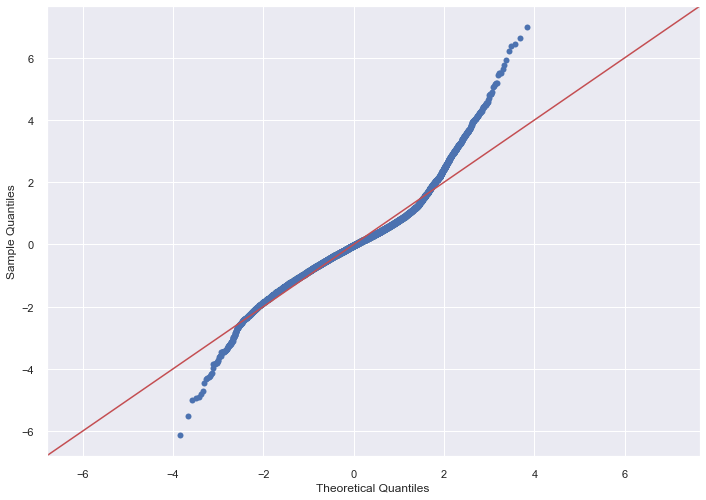

In [927]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

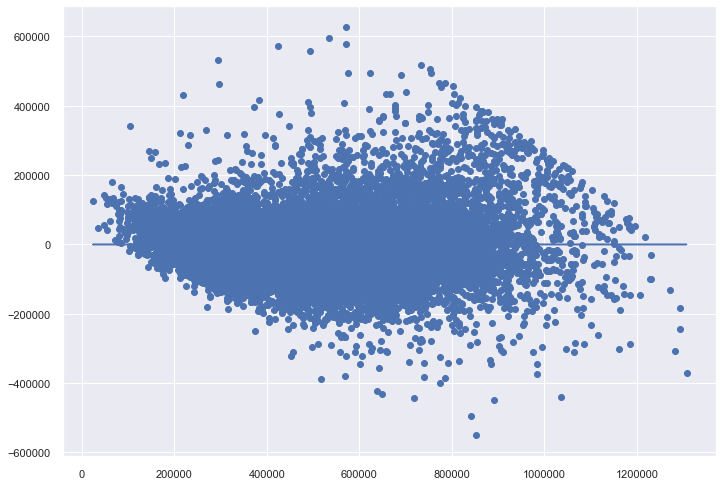

In [928]:
plt.scatter(model.predict(x_train), model.resid)
plt.plot(model.predict(x_train), [0 for i in range(len(x_train))]);

In [929]:
#create a dataframe to address multicolinearity
df_fin_mcl = df_fin_cat.corr().abs().stack().reset_index().sort_values(0,ascending=False)
df_fin_mcl['pairs'] = list(zip(df_fin_mcl.level_0,df_fin_mcl.level_1))
df_fin_mcl.set_index(['pairs'],inplace=True)
df_fin_mcl.drop(columns=['level_0','level_1'],inplace=True)
df_fin_mcl.columns = ['Correlation']
df_fin_mcl.drop_duplicates(inplace=True)
df_fin_mcl[(df_fin_mcl.Correlation>.70)&(df_fin_mcl.Correlation<1)]

Correlation
pairs                                          
(sqft_above, sqft_living)              0.857486
(res_condition_3, res_condition_2)     0.815930
(sqft_living15, sqft_living)           0.743393
(sqft_above, sqft_living15)            0.721484

In [930]:
#let's drop some features thas have the multicolinearity more than 70%
df_fin_cat.drop(columns=['sqft_above','res_condition_3','sqft_living15'],axis=1,inplace=True)

It seems that we address multicolinearity and the RMSE went higher!
* Our Train RMSE increased from 89765 to 91202
* Our Test RMSE increased from 92707 to 94503


In [931]:
y = df_fin_cat[['price']]
x = df_fin_cat.drop(['price'],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=52)

# it calculates the intercept and it doesn't need to be calculated separately
# x_train = sm.add_constant(x_train)
# x_test = sm.add_constant(x_test)

linreg.fit(x_train,y_train)

y_hat_train = linreg.predict(x_train)
y_hat_test = linreg.predict(x_test)
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Root Mean Squarred Error:', train_mse**0.5)
print('Test Root Mean Squarred Error:', test_mse**0.5)

Train Root Mean Squarred Error: 91202.32846020392
Test Root Mean Squarred Error: 94503.31976625283


Let's check how it will affect our model fit (R2)
* our R-squared decreased from 0.841 to 0.835

In [932]:
target = 'price'
predictors = '+'.join(x_train.columns)
train = pd.concat([x_train,y_train], axis=1)
formula = target + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     753.9
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:35:55   Log-Likelihood:            -2.1319e+05
No. Observations:               16604   AIC:                         4.266e+05
Df Residuals:                   16492   BIC:                         4.275e+05
Df Model:                         111                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -8.635e+07   6.28e+06    -13.757      0.000   -9.86e+07    -7.4e+07
date_sold          92.2348      6.337     14.556      0.000      79.814     104.655
sqft_living       117.9433      1.862     63.352      0.000     114.294     121.592
sqft_lot            0.3223      0.020     16.238      0.000       0.283       0.361
yr_built         -505.0402     45.092    -11.200      0.000    -593.426    -416.655
lat             -2.731e+04   4.32e+04     -0.631      0.528   -1.12e+05    5.75e+04
long            -1.718e+05   3.08e+04     -5.574      0.000   -2.32e+05   -1.11e+05
waterfront_1     3.308e+05   1.32e+04     25.119      0.000    3.05e+05    3.57e+05
res_condition_1 -5.837e+04   8179.149     -7.136      0.000   -7.44e+04   -4.23e+04
res_condition_2  -1.85e+04   1860.216     -9.948      0.000   -2.22e+04   -1.49e+04
res_condition_4  3.195e+04   2969.700     10.759      0.000    2.61e+04    3.78e+04
floors_2        -8251.0442   2297.684     -3.591      0.000   -1.28e+04   -3747.336
floors_3        -4.959e+04   5477.996     -9.053      0.000   -6.03e+04   -3.89e+04
bedrooms_2       9751.1144   7856.447      1.241      0.215   -5648.370    2.52e+04
bedrooms_3       1.627e+04   7881.840      2.065      0.039     823.380    3.17e+04
bedrooms_4        1.28e+04   8064.262      1.587      0.112   -3007.241    2.86e+04
bedrooms_5      -1076.8209   8552.524     -0.126      0.900   -1.78e+04    1.57e+04
bedrooms_6      -2.681e+04   1.07e+04     -2.502      0.012   -4.78e+04   -5804.374
bedrooms_7      -6.827e+04   2.05e+04     -3.329      0.001   -1.08e+05   -2.81e+04
bedrooms_8      -8.761e+04   3.36e+04     -2.609      0.009   -1.53e+05   -2.18e+04
bedrooms_9        408.8850   6.57e+04      0.006      0.995   -1.28e+05    1.29e+05
bedrooms_10     -5.859e+04   4.68e+04     -1.253      0.210    -1.5e+05    3.31e+04
zipcode_98002    7405.4029   9045.778      0.819      0.413   -1.03e+04    2.51e+04
zipcode_98003    -1.02e+04   8201.842     -1.244      0.214   -2.63e+04    5876.206
zipcode_98004    4.696e+05   1.62e+04     28.931      0.000    4.38e+05    5.01e+05
zipcode_98005    2.559e+05   1.68e+04     15.220      0.000    2.23e+05    2.89e+05
zipcode_98006    2.171e+05   1.38e+04     15.743      0.000     1.9e+05    2.44e+05
zipcode_98007    1.922e+05    1.7e+04     11.330      0.000    1.59e+05    2.25e+05
zipcode_98008    1.882e+05   1.63e+04     11.546      0.000    1.56e+05     2.2e+05
zipcode_98010    9.445e+04   1.43e+04      6.589      0.000    6.64e+04    1.23e+05
zipcode_98011    6.872e+04   2.11e+04      3.253      0.001    2.73e+04     1.1e+05
zipcode_98014    8.436e+04   2.33e+04      3.626      0.000    3.88e+04     1.3e+05
zipcode_98019    6.985e+04   2.26e+04      3.096      0.002    2.56e+04    1.14e+05
zipcode_98022    2.492e+04    1.3e+04      1.920      0.055

Address insignificant p-values:
* deleteing p-values which are highr than 0.05

In [933]:
target = 'price'
x_cols = list(df_fin_cat.columns)
x_cols.remove(target)

In [935]:
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))

p_table.head()

112 92


0                  coef    std err          t  P>|t|     [0.025     0.975]
                                                                          
Intercept    -8.635e+07   6.28e+06    -13.757    0.0  -9.86e+07   -7.4e+07
date_sold       92.2348      6.337     14.556    0.0     79.814    104.655
sqft_living    117.9433      1.862     63.352    0.0    114.294    121.592
sqft_lot         0.3223      0.020     16.238    0.0      0.283      0.361
yr_built      -505.0402     45.092    -11.200    0.0   -593.426   -416.655

As we can see above there were 92 significant p-values and there were 20 insignificant p-values that were removed

In [942]:
pv_trim_train = x_train[x_cols]
pv_trim_test = x_test[x_cols]
linreg.fit(pv_trim_train,y_train)


y_hat_train = linreg.predict(pv_trim_train)
y_hat_test = linreg.predict(pv_trim_test)

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Root Mean Squarred Error:', train_mse**0.5)
print('Test Root Mean Squarred Error:', test_mse**0.5)

Train Root Mean Squarred Error: 98562.33764767072
Test Root Mean Squarred Error: 101098.96771219186


by deleting features with p-values higher than 0.05 RMSE increased!

In [936]:
predictors = '+'.join(x_cols)
train = pd.concat([x_train,y_train], axis=1)
formula = target + "~" + predictors
model = ols(formula=formula, data=train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.807
Method:                 Least Squares   F-statistic:                     753.9
Date:                Mon, 23 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:46:37   Log-Likelihood:            -2.1448e+05
No. Observations:               16604   AIC:                         4.291e+05
Df Residuals:                   16511   BIC:                         4.299e+05
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -7.998e+07   5.93e+06    -13.477      0.000   -9.16e+07   -6.83e+07
date_sold          85.0310      6.840     12.432      0.000      71.624      98.438
sqft_living       162.2999      1.542    105.276      0.000     159.278     165.322
sqft_lot            0.3709      0.021     17.380      0.000       0.329       0.413
yr_built          -61.0060     46.364     -1.316      0.188    -151.884      29.872
long            -1.443e+05   2.54e+04     -5.683      0.000   -1.94e+05   -9.45e+04
waterfront_1     3.425e+05   1.42e+04     24.151      0.000    3.15e+05     3.7e+05
res_condition_1 -6.063e+04   8809.754     -6.883      0.000   -7.79e+04   -4.34e+04
res_condition_2 -1.598e+04   2003.253     -7.977      0.000   -1.99e+04   -1.21e+04
res_condition_4  2.998e+04   3201.016      9.367      0.000    2.37e+04    3.63e+04
floors_2         1456.0977   2457.438      0.593      0.554   -3360.745    6272.940
floors_3        -3.748e+04   5862.589     -6.393      0.000    -4.9e+04    -2.6e+04
bedrooms_3       8900.6661   1643.870      5.414      0.000    5678.503    1.21e+04
bedrooms_6      -7.166e+04   7505.295     -9.548      0.000   -8.64e+04    -5.7e+04
bedrooms_7      -1.253e+05   2.03e+04     -6.169      0.000   -1.65e+05   -8.55e+04
bedrooms_8      -1.728e+05   3.51e+04     -4.920      0.000   -2.42e+05   -1.04e+05
zipcode_98004    4.714e+05   1.05e+04     45.039      0.000    4.51e+05    4.92e+05
zipcode_98005    2.672e+05   1.13e+04     23.732      0.000    2.45e+05    2.89e+05
zipcode_98006    2.307e+05   8484.839     27.186      0.000    2.14e+05    2.47e+05
zipcode_98007    1.938e+05   1.13e+04     17.094      0.000    1.72e+05    2.16e+05
zipcode_98008    1.749e+05   9599.621     18.221      0.000    1.56e+05    1.94e+05
zipcode_98010     7.99e+04    1.2e+04      6.673      0.000    5.64e+04    1.03e+05
zipcode_98011    4.928e+04   1.04e+04      4.747      0.000    2.89e+04    6.96e+04
zipcode_98014    4.189e+04   1.51e+04      2.781      0.005    1.24e+04    7.14e+04
zipcode_98019    1.903e+04   1.19e+04      1.596      0.111   -4343.979    4.24e+04
zipcode_98023   -2.429e+04   6676.750     -3.638      0.000   -3.74e+04   -1.12e+04
zipcode_98024    8.034e+04   1.63e+04      4.930      0.000    4.84e+04    1.12e+05
zipcode_98027    1.506e+05   8244.036     18.264      0.000    1.34e+05    1.67e+05
zipcode_98028    3.587e+04   9449.443      3.797      0.000    1.74e+04    5.44e+04
zipcode_98029    1.753e+05   1.02e+04     17.162      0.000    1.55e+05    1.95e+05
zipcode_98030     1.43e+04   7612.188      1.879      0.060    -616.696    2.92e+04
zipcode_98031    2.055e+04   7397.201      2.778      0.005    6050.385     3.5e+04
zipcode_98033    2.536e+05   8642.955     29.344      0.000    2.37e+05    2.71e+05
zipcode_98034    8.952e+04   8206.860     10.909      0.000

In [964]:
df['location'] = df.apply(finding_location, axis=1)

In [968]:
df.rename(columns={"res_condition": "condition", "res_grade": "grade"},inplace=True)

In [969]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
date_sold        21597 non-null int64
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null int64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null int64
waterfront       21597 non-null int64
sqft_above       21597 non-null int64
yr_built         21597 non-null int64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
basement         21597 non-null int64
renovated        21597 non-null int64
condition        21597 non-null int64
grade            21597 non-null int64
city             21597 non-null object
location         21597 non-null object
dtypes: float64(3), int64(16), object(2)
memory usage: 3.5+ MB


In [970]:
df.to_csv('df_cleaned.csv',index=False)